<a href="https://colab.research.google.com/github/ma850419/Fast_UNet/blob/main/copy_of_copy_of_oco3_oco2_processing_1july2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# first step
import geopandas as gpd
from shapely.geometry import Polygon

C:\Users\anaconda3\envs\venv\Lib\site-packages\pyproj\__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [ ]:
"""
---------------------------------------------------------------------------------------------------
 How to Access the LP DAAC Data Pool with Python
 The following Python code example demonstrates how to configure a connection to download data from
 an Earthdata Login enabled server, specifically the LP DAAC's Data Pool.
---------------------------------------------------------------------------------------------------
 Author: Cole Krehbiel
 Last Updated: 05/14/2020
---------------------------------------------------------------------------------------------------
"""
# Load necessary packages into Python
from subprocess import Popen
from getpass import getpass
#from netrc import netrc
import argparse
import time
import os
import requests

# ----------------------------------USER-DEFINED VARIABLES--------------------------------------- #
# Set up command line arguments
'''parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('-dir', '--directory', required=True, help='Specify directory to save files to')
parser.add_argument('-f', '--files', required=True, help='A single granule URL, or the location of csv or textfile containing granule URLs')
args = parser.parse_args()'''

#saveDir = args.directory  # Set local directory to download to
saveDir='C:/ncd_oco-3'
files='C:/ncd_oco-3/file_lists.txt'
#files = args.files        # Define file(s) to download from the LP DAAC Data Pool
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# ---------------------------------SET UP WORKSPACE---------------------------------------------- #
# Create a list of files to download based on input type of files above
if files.endswith('.txt') or files.endswith('.csv'):
    fileList = open(files, 'r').readlines()  # If input is textfile w file URLs
elif isinstance(files, str):
    fileList = [files]                       # If input is a single file

# Generalize download directory
if saveDir[-1] != '/' and saveDir[-1] != '\\':
    saveDir = saveDir.strip("'").strip('"') + os.sep
urs = 'urs.earthdata.nasa.gov'    # Address to call for authentication

# --------------------------------AUTHENTICATION CONFIGURATION----------------------------------- #
# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser("~/.netrc")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}.netrc | chmod og-rw {0}.netrc | echo machine {1} >> {0}.netrc'.format(homeDir + os.sep, urs), shell=True)
    Popen('echo login {} >> {}.netrc'.format(getpass(prompt=prompts[0]), homeDir + os.sep), shell=True)
    Popen('echo password {} >> {}.netrc'.format(getpass(prompt=prompts[1]), homeDir + os.sep), shell=True)

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}.netrc'.format(homeDir + os.sep, urs), shell=True)
    Popen('echo login {} >> {}.netrc'.format(getpass(prompt=prompts[0]), homeDir + os.sep), shell=True)
    Popen('echo password {} >> {}.netrc'.format(getpass(prompt=prompts[1]), homeDir + os.sep), shell=True)

# Delay for up to 1 minute to allow user to submit username and password before continuing
tries = 0
while tries < 30:
    try:
        netrc(netrcDir).authenticators(urs)[2]
    except:
        time.sleep(2.0)
    tries += 1

# -----------------------------------------DOWNLOAD FILE(S)-------------------------------------- #
# Loop through and download all files to the directory specified above, and keeping same filenames
for f in fileList:
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    saveName = os.path.join(saveDir, f.split('/')[-1].strip())

    # Create and submit request and download file
    with requests.get(f.strip(), verify=False, stream=True, auth=(netrc(netrcDir).authenticators(urs)[0], netrc(netrcDir).authenticators(urs)[2])) as response:
        if response.status_code != 200:
            print("{} not downloaded. Verify that your username and password are correct in {}".format(f.split('/')[-1].strip(), netrcDir))
        else:
            response.raw.decode_content = True
            content = response.raw
            with open(saveName, 'wb') as d:
                while True:
                    chunk = content.read(16 * 1024)
                    if not chunk:
                        break
                    d.write(chunk)
            print('Downloaded file: {}'.format(saveName))

In [2]:
# Secoond step
## Preprocessing: retrieve data from netCDF and convert to pandas columns

import netCDF4 # packages to open 'netcdf' file
import numpy as np # numpy and pandas packages to pre-process the dataset
import pandas as pd

# Data access from OPENDAP source

from urllib import request, parse
import getpass
import netrc
import os
import requests
import os
import time
from netCDF4 import Dataset
# pydap library to open session
from pydap import client
from pydap.cas.urs import setup_session
from pydap.client import open_url
import json
# For visualization and plotting
import matplotlib.pyplot as plt # to create plots and graphs
from mpl_toolkits.basemap import Basemap # to create geo-spatial map, requires dependencies installation
import plotly.express as px
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.collections import PatchCollection
import time
import matplotlib
import lxml
import html5lib
# To load webcontent and retrieve data from link
from IPython.display import display, HTML
from IPython import display
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Cleaning
import gc
import sys

# Web Scrap for the contents
import re

# To grab data from entire year, month
from bs4 import BeautifulSoup #

## GEOPY package to locate the region
from geopy.geocoders import Nominatim
import geopy

In [ ]:
import earthaccess
def get_session(url, file_name):
    """
    Creating a session with url and filename in openDap for data retrieval
    https://oco2.gesdisc.eosdis.nasa.gov/opendap/
    """
    print('inside get_session\n')
    print(file_name)
    auth = earthaccess.login()
    auth.refresh_tokens()
    try:
##        login_credentials= 'uat.urs.earthdata.nasa.gov'
        login_credentials= 'urs.earthdata.nasa.gov'
        username, _, password = netrc.netrc().authenticators(login_credentials)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('\n*******************************************\n')
        print('Please provide your Earthdata Login credentials to allow data access\n')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (url))
        print('\n')
        username = input('Username: ')
        password = getpass.getpass()
        print('\n*******************************************\n')

    # pydap session
    print(url + file_name)
    session = setup_session(username, password, check_url= url + file_name)

    # using the session to get access the data
    return session

In [ ]:
# third step
%%time
print("OCO3 currently has -> 10 vr.\n")
## Input to select year and data version
## For year, enter 2021, for month, enter 06 (not just "6"). For version, enter 10
## After the files are retrieved, click on the next cell below to continue the run.

year= input("Enter the Year: ")
month= input("Enter the Month: ")
ver_= input("Enter the version: ")

## FORMAT the filenames by VERSION and YEAR
## RETRIEVE all filenames for the YEAR using webscraping
## OCO3
lite_file= '/OCO3_L2_Lite_FP.'+ str(ver_)+ '.4r' +'/'+ year

########################################################################
# GET THE files from OpenDap source. Open the netcdf file and store in dataframe
# Beautiful soup to retrieve all data for the input time period
########################################################################

main_url='https://oco2.gesdisc.eosdis.nasa.gov/opendap'
content= '/contents.html'

s= requests.get(main_url + lite_file + content)
## Scrap the content by specified URL
## Get the entire filenames of the searched YEAR
soup= BeautifulSoup(s.content, 'html.parser')
list_files=[]
#print(soup)
## regex expression to GET netCDF files
html_links= soup.select('a[href$=".nc4.html"]')
#print(html_links)
#print(href)
for link in html_links:
    list_files.append(link['href'])
    #print(link)
## pre-process the filenames; strings, CLEAN the files
# removing last strings '.html' to download the files from PYDAP library to match file names
files_oco2= [f[:-5] for f in list_files]

# total_files= ['opendap'+lite_file+'/'+ f for f in files_oco2[:3]]
total_files= [lite_file+'/'+ f for f in files_oco2]
#print(len(total_files))
## get alternate row files; duplicate ROWS on html LINKS
#total_files= total_files[::2]
#print(len(total_files[::2]))
## print(total_files)

In [ ]:
# 4th step
url=main_url
print(main_url)
print(total_files[3])

In [ ]:
# 5th step
session= get_session(url, total_files[0])

In [ ]:
#len([f for f in total_files if f.startswith(total_files[2][:41] + month) ])
len(total_files[0])

In [ ]:
# 6th step
total_= [f for f in total_files if f.startswith(total_files[0][:41] + month) ]

In [ ]:
len(total_)

In [ ]:
print(total_[0:2])

In [ ]:
# 7th step
data_dir_check = os.path.isdir('./data_march_2020_2023')
print("Data directory exists: ",data_dir_check)

if data_dir_check != True:
    os.makedirs('./data_march_2020_2023')
    print("Created local data directory")

In [ ]:
# 8th step
%%time
from scipy.interpolate import griddata
# session.post
##Let all files get processed before proceeding, each one takes a few seconds to process.
## list of pydap variables
xco2=[]
long_vertices=[]
lat_vertices=[]
sounding_id=[]
qual_flag=[]
dates=[]
if session:
#     print("alive")
    for j in range(0, len(total_)):
        print('====================================')
        print(main_url + total_[j])
        print('====================================')
        pydap_df= open_url(main_url + total_[j], session=session)
        print("I am here", pydap_df.attributes.keys)
        #################################################
        # collect the data
        dates.append(pydap_df["date"][:])
        xco2.append(np.array(pydap_df["xco2"][:]))
        long_vertices.append(pydap_df["vertex_longitude"][:])
        lat_vertices.append(pydap_df["vertex_latitude"][:])
        qual_flag.append(pydap_df["xco2_quality_flag"][:])
        print('***********************/n')
else:
    print("request new session")

In [ ]:
import os
import numpy as np
from netCDF4 import Dataset

# Initialize the arrays
dates = []
xco2 = []
long_vertices = []
lat_vertices = []
qual_flag = []

# Directory containing the netCDF files
directory = "D:/OCO2-OCO3 data/OCO3_L2_Lite_FP_10.4r-20240912_150123/"

# Function to read and append data from a netCDF file
def read_nc_file(file_path):
    try:
        with Dataset(file_path, 'r') as nc_file:
            df = {
                "date": np.array(nc_file.variables['date'][:]),
                "xco2": np.array(nc_file.variables['xco2'][:]),
                "vertex_longitude": np.array(nc_file.variables['vertex_longitude'][:]),
                "vertex_latitude": np.array(nc_file.variables['vertex_latitude'][:]),
                "xco2_quality_flag": np.array(nc_file.variables['xco2_quality_flag'][:])
            }

            dates.append(df["date"])
            xco2.append(df["xco2"])
            long_vertices.append(df["vertex_longitude"])
            lat_vertices.append(df["vertex_latitude"])
            qual_flag.append(df["xco2_quality_flag"])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Iterate through all files in the directory and read the netCDF files for the year 2020
for filename in os.listdir(directory):
    if filename.endswith(".nc4") and filename[11:13] == "20" and int(filename[13:15]) >= 9:
        file_path = os.path.join(directory, filename)
        print(file_path)
        read_nc_file(file_path)

# Check if lists are not empty before concatenating

print(f"Dates: {len(dates)}, XCO2: {len(xco2)}, Longitude Vertices: {len(long_vertices)}, Latitude Vertices: {len(lat_vertices)}, Quality Flags: {len(qual_flag)}")



In [ ]:
import pandas as pd
print(xco2[50][10000],dates[50][10000], long_vertices[50][10000])

In [ ]:
# 8th step
%%time
##################################################
# 1. Create pandas dataframe to filter the values

df_oco3= pd.DataFrame()
df_oco3["Dates"]=  list(np.array(np.concatenate(dates)))
df_oco3["Xco2"]= np.array(np.concatenate(xco2)).ravel()
df_oco3["Longitude_vertices"]= list(np.array(np.concatenate(long_vertices)))
df_oco3["Latitude_vertices"]= list(np.array(np.concatenate(lat_vertices)))
df_oco3["quality_flag"]= np.array(np.concatenate(qual_flag)).ravel()

del xco2
del long_vertices
del lat_vertices
del qual_flag
gc.collect()

##################################################
# Filter the DATA by quality flag-> 0
df_oco3= df_oco3[df_oco3["quality_flag"]== 0]
df_oco3=df_oco3.reset_index()
df_oco3= df_oco3.drop(columns=["index"])

#################################################
# 2. DSTACK the vertices of corner points together
flat_vertices=[]
for j in range(0, len(df_oco3)):
    flat_vertices.append(np.dstack([df_oco3["Longitude_vertices"].iloc[j], df_oco3["Latitude_vertices"].iloc[j] ]))

##################################################
# 3. GET patches from the vertices
## unpack the values from the list
unpack_vertices= [elem for sublist in flat_vertices for elem in sublist]
patches_total= [mpatches.Polygon(row) for row in unpack_vertices]

##################################################
## XCO2 values
xco2_total= df_oco3["Xco2"][:]

## Garbage Collect, release memory
#del df_oco3
gc.collect()

In [ ]:
#An **inverse flux model** is a method used to estimate the sources and sinks of greenhouse gases (like CO2) by using observed concentration data and atmospheric transport models. Essentially, it works by "inverting" the process: instead of predicting concentrations from known emissions, it infers emissions from observed concentrations.

#Here's a simple Python program to calculate fluxes from XCO2 data using an inverse model approach:

#python
import numpy as np

def calculate_fluxes(xco2_data, transport_matrix):
    """
    Calculate fluxes from XCO2 data using an inverse model approach.

    Parameters:
    xco2_data (numpy array): Array of XCO2 data.
    transport_matrix (numpy array): Transport matrix representing the atmospheric transport model.

    Returns:
    numpy array: Calculated fluxes.
    """
    # Perform the inverse calculation to estimate fluxes
    fluxes = np.linalg.inv(transport_matrix).dot(xco2_data)
    conversion_factor = 1.0  # Placeholder value, adjust based on your specific needs
    fluxes_gC_m2_day = fluxes * conversion_factor
    fluxes_gC_year = fluxes_gC_m2_day * 365  # gC/m²/year
    fluxes_tC_year = fluxes_gC_year / 1e6  # tC/year
    fluxes_GtC_year = fluxes_tC_year / 1e9  # GtC/year

    return fluxes_GtC_year
    #return fluxes_gC_m2_day


# Example XCO2 data (in ppm)
xco2_data = np.array([400.5, 401.0, 399.8, 400.2, 401.5])

# Example transport matrix (this should be derived from an atmospheric transport model)
transport_matrix = np.array([
    [0.8, 0.1, 0.05, 0.03, 0.02],
    [0.1, 0.7, 0.1, 0.05, 0.05],
    [0.05, 0.1, 0.75, 0.05, 0.05],
    [0.03, 0.05, 0.05, 0.8, 0.07],
    [0.02, 0.05, 0.05, 0.07, 0.81]
])

# Calculate the fluxes
fluxes = calculate_fluxes(xco2_data, transport_matrix)

print("Calculated fluxes:", fluxes)
'''

This code defines a function `calculate_fluxes` that takes XCO2 data and a transport matrix as inputs and returns the calculated fluxes. The transport matrix represents the atmospheric transport model, which should be derived from a more detailed atmospheric model.

Feel free to ask if you need further details or have any other questions!

Source: Conversation with Copilot, 9/20/2024
(1) LECTURES ON INVERSE MODELING - Harvard University. https://projects.iq.harvard.edu/files/acmg/files//jacob_lectures_inverse_modeling.pdf.
(2) Inverse modelling of greenhouse gas fluxes from atmosphere ... - ICOS. https://www.icos-cp.eu/sites/default/files/2018-08/AbstractsV6_0.pdf.
(3) Inverse-square law - Wikipedia. https://en.wikipedia.org/wiki/Inverse-square_law.
(4) Technical note: A high-resolution inverse modelling technique for .... https://acp.copernicus.org/articles/21/1245/2021/.'''

In [ ]:
print(df_oco3.loc[0].iat[2])

In [ ]:
# 9th step
# OCO-3 mean values of July month are written to CSV file
import pandas as pd
# save the dataframe as a csv file
df_oco3.to_csv("./Oco3_2020_9to12months_withdate.csv")

In [ ]:
def conv(val):
  Lon= list( val.split())
  Lon= [float(i) for i in Lon]
  return Lon

In [ ]:
import shapely
print(shapely.__version__)
import geopandas as gpd
print(gpd.__version__)

In [ ]:
# 10th step
%%time
import datetime
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
filename="./Oco3_2020_9to12months_withdate.csv"
df = pd.read_csv(filename)
#arr= np.zeros((len(df),3)).astype(float)
#arr1= np.zeros((len(df),1), dtype='datetime64[ns]')#np.zeros((len(df),1)).astype(datetime)
dtype1 = np.dtype([('date', 'datetime64[D]'),('time', 'datetime64[ns]'), ('XCO2', np.float64), ('Long', np.float64),('Lat', np.float64),('qlt', np.int64)])
arr2 = np.zeros((len(df),)).astype(dtype1)
for i in range(len(df)):
    date_ =  datetime.datetime.strptime(df.loc[i].iat[1][1:-6], "%Y    %m    %d    %H    %M    %S")
    print(date_)
    milliseconds = int(df.loc[i].iat[1][-4:-1])
    print(milliseconds)
    date_ = date_.replace(microsecond=milliseconds * 1000)
    print(date_)
    lon_point_list = conv(df.loc[i].iat[3][1:-1])
    print(lon_point_list)
    lat_point_list = conv(df.loc[i].iat[4][1:-1])
    print(type(lat_point_list))
    polygon_geom = Polygon(list(zip(lon_point_list, lat_point_list)))
   #polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])
    centroid=polygon_geom.centroid
    #print(centroid)
    #centroid = polygon.centroid  # Correct variable name
    #data = list(zip(lon_point_list, lat_point_list))
    #%timeit centeroidpython(data)
    arr2[i]['date'] = date_ # Assign values to fields of the structured array
    arr2[i]['time'] = date_
    arr2[i]['XCO2'] = df.loc[i].iat[2]
    arr2[i]['Long'] = centroid.x #.iloc[0].x  # Access centroid coordinates correctly
    arr2[i]['Lat'] = centroid.y #.iloc[0].y
    arr2[i]['qlt'] = df.loc[i].iat[5]
    #print(arr[i])
#print(arr1.shape)
#print(arr.shape)
#arr2 = np.hstack((arr1,arr))
DF = pd.DataFrame(arr2)
DF.to_csv("./OCO_3_formated_2020_sep_dec.csv")
#polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
#polygon.to_file(filename='polygon.gpkg', driver="GPKG")
#polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

In [ ]:
# 11th step
%%time
from scipy.interpolate import griddata
time_series_a = []
version_str = 'B11100Ar'
file = ''
latitude_max = 40.0
latitude_min = -40.0
longitude_max = 180.0
longitude_min = -180.0
print(len(arr2))
alldates= np.unique(arr2[:]['date'])
print(alldates)
for j in range (len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
  # Read the data from your variables
  latitude = arr3[:]['Lat']
  longitude = arr3[:]['Long']
  x_meas = arr3[:]['XCO2']
  qf = arr3[:]['qlt']
  print(latitude)
  print(longitude)
  print(x_meas)
  print(qf)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]

  # Apply the subset selection to data variables
  latitude = latitude[selection_only]
  longitude = longitude[selection_only]
  x_meas = x_meas[selection_only]

  pixel_size_deg = 0.1 # 5x5 degree grid resolution

  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)

  time_series_a.append(grid_x)

time_series_a = np.array(time_series_a)
print(time_series_a.shape)
x_meas_month_mean_a = np.mean(time_series_a, axis=0)
print(x_meas_month_mean_a.shape)

In [ ]:
# 12th step
"""
1. Pass the xco2 values and Patches values generated from POLYGON shape
2. Use either `Dark` or `ArcGis` Theme
3. Pass the bounding box information
4. Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
5. Pass the location string
6. Pass the YEAR and MONTH from previous search criteria to OPENDAP
"""
def plot_vertices(xco2_data, patches, bbx_list_info, location, year, month):
    # ## XCO2 values
    # xco2_total= xco2_list

    ## plot to graph using basemap
    fig= plt.figure(111)
    ax= fig.add_subplot(111)

    ## You can set the MIN and MAX boundaries for XCO2
    xco2_min_= 402
    xco2_max_= 430

    # world map:
    # set the boundaries
#     llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat= -180, 90, -90, 90


##   Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
    offset= 1
    llcrnrlon= bbx_list_info[2] - offset
    urcrnrlon= bbx_list_info[3] + offset
    llcrnrlat= bbx_list_info[0] - offset
    urcrnrlat= bbx_list_info[1] + offset

    # ###worldmap (FULL_OUTER_MAP)
    m= Basemap(projection= 'cyl',
            llcrnrlon= llcrnrlon,
            urcrnrlon= urcrnrlon,
            llcrnrlat= llcrnrlat,
            urcrnrlat= urcrnrlat,
            resolution='l',
            epsg= 4269
            )

    ## DARK theme map (you can choose any theme based on your preference from the library)
    #m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
    #m.drawmapboundary(fill_color='#000000')

    ### ArcGIS map
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS',
                  #service='World_Shaded_Relief',
                  service='World_Imagery',
                  xpixels=2000, ypixels=None, dpi= 2000, verbose=False)


    cmap= plt.get_cmap('viridis')
    colors= cmap(xco2_total)

    ## normalize
    norm= matplotlib.colors.Normalize(vmin= xco2_min_,
                                     vmax= xco2_max_)

    ## PATCHES object passed to this function
    ## patch collection and plt show
    p= PatchCollection(patches_total,
                       cmap= matplotlib.cm.viridis,
                       #alpha= 0.95,
                      # linewidths= 4
                       edgecolor='none',
                       norm= norm
                      )

    # set color range from XCO2
    #p.set_color(colors)
    p.set_array(xco2_total)
    #p.set_clim(np.min(xco2), np.max(xco2))

    plt.gcf().set_size_inches(10, 10)
    ax.add_collection(p)

    ## COLOR bar
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=xco2_min_, vmax=xco2_max_)
    cbar= plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=plt.gca(),
                       orientation='horizontal', label='OCO3, XCO2 ppm\n'+'Year: '+
                       str(year)+ ' Months: '+ str(month)+'\n'+
                      str(location).upper())
    #                   + str(months_sel))
    #    plt.savefig('dark'+str(year)+'_'+str(months_sel)+"_oco2_oco3_comb.jpg", dpi= 3500, bbox_inches='tight', pad_inches= 2)
    plt.show();

In [ ]:
%%time
## For an urban location, enter a city, i.e., "san francisco" (without quotes) then hit RETURN
location= input("Enter the location: ")
geo_loc= Nominatim(user_agent="locate", timeout=4)
info= geo_loc.geocode(str(location)).raw
## get the Bounding box information
loc_bbx= info["boundingbox"]
bbx_list= [float(i) for i in loc_bbx]
print('\n************************************\n')
print("Bbox information of :\n"+f'{location}')
bbx_list
year= input("Enter the Year: ")
month= input("Enter the Month: ")
# plot the location
plot_vertices(xco2_total, patches_total, bbx_list, location, year, month)

The Begining of the OCO-2 processing

In [3]:
# 1st step in OCO2
import os
import requests
import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()
#import datetime
import contextlib

from pathlib import Path

import pandas as pd
import glob

import numpy as np
import netCDF4
from netCDF4 import Dataset

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata

In [ ]:
!pip install earthaccess
!pip install Basemap
!pip install xesmf

In [ ]:
!pip install netCDF4

In [ ]:
# 2nd step in OCO2
%%time
auth = earthaccess.login(strategy="interactive", persist=True)

auth.login(strategy="netrc")
authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

In [ ]:
# 3rdstep in OCO2
%%time
auth = earthaccess.login(strategy="interactive", persist=True)

auth.login(strategy="netrc")
authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

In [ ]:
# 4th step make sure to change folder or keep it
%%time
data_dir_check = os.path.isdir('./OCO2_data_2020')
print("Data directory exists: ",data_dir_check)

if data_dir_check != True:
    os.makedirs('./OCO2_data_2020')
    print("Created local data directory")

In [ ]:
# 5th step
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

In [ ]:
# 6th step
%%time
url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request to check that we can access CMR
response = cmr_request(url)

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

In [ ]:
# 7th step
%%time
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.5067/8E4VLCK16O6Q'                   # OCO-2 dataset DOI

doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

shortname = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
longname = requests.get(doisearch).json()['feed']['entry'][0]['dataset_id']
version_id = requests.get(doisearch).json()['feed']['entry'][0]['version_id']
print('Short Name = '+shortname)
print('Long Name = '+longname)
print('Version Identifier = '+version_id)

In [ ]:
# 8th step
# Define the quality flag variabe to utilize; in this case, we select 'xco2_quality_flag'.
qfvar = 'xco2_quality_flag'

# Define Measurement Variable Type; in this test case, we select 'xco2'.
measurement = 'xco2'


In [ ]:
# 9th step of OCO2
%%time
# Define the start and end date/time (YYYY-MM-DD).
start_time = '2020-01-08'
end_time = '2020-01-08'

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id).temporal(start_time, end_time)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

In [ ]:
the correct one

In [ ]:
# 9th step of OCO2
try:
    files = store.get(granules[:], local_path="./OCO2_data_2020")
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./OCO2_data_2020")

In [ ]:
import os
import numpy as np
from netCDF4 import Dataset

# Initialize the arrays
dates = []
xco2 = []
long_vertices = []
lat_vertices = []
qual_flag = []

# Directory containing the netCDF files
directory = "./OCO2_data_2020/"

# Function to read and append data from a netCDF file
def read_nc_file(file_path):
    try:
        with Dataset(file_path, 'r') as nc_file:
            df = {
                "date": np.array(nc_file.variables['date'][:]),
                "xco2": np.array(nc_file.variables['xco2'][:]),
                "vertex_longitude": np.array(nc_file.variables['vertex_longitude'][:]),
                "vertex_latitude": np.array(nc_file.variables['vertex_latitude'][:]),
                "xco2_quality_flag": np.array(nc_file.variables['xco2_quality_flag'][:])
            }

            dates.append(df["date"])
            xco2.append(df["xco2"])
            long_vertices.append(df["vertex_longitude"])
            lat_vertices.append(df["vertex_latitude"])
            qual_flag.append(df["xco2_quality_flag"])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Iterate through all files in the directory and read the netCDF files for the year 2020
for filename in os.listdir(directory):
    if filename.endswith(".nc4") and filename[11:13] == "20" and int(filename[13:15]) <= 4:
        file_path = os.path.join(directory, filename)
        print(file_path)
        read_nc_file(file_path)

# Check if lists are not empty before concatenating

print(f"Dates: {len(dates)}, XCO2: {len(xco2)}, Longitude Vertices: {len(long_vertices)}, Latitude Vertices: {len(lat_vertices)}, Quality Flags: {len(qual_flag)}")

In [ ]:
# do not use this
%%time
time_series_a = []
version_str = 'B11100Ar'
file = ''

# Loop through the date range and plot Carbon Dioxide for each day
for current_date in pd.date_range(start_time, end_time):
    # Open the netCDF file
    file_date = current_date.strftime("%y%m%d")
    file_path_prefix = './data_march_2020_2023/oco2_LtCO2_'+file_date+'_'+version_str+'_'
    file_path = glob.glob(file_path_prefix+'*.nc4')
    print(file_path)
    if file_path != []:
        print('File date = ',file_date)
        #print('File path prefix = ',file_path_prefix)
        print('File path = ',file_path)

        file = file.join(file_path)

        # Open the netCDF file
        dataset = Dataset(f'{file}', 'r')
        print("reading data from =", file_date)

        # Read the data from your variables
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
        x_meas = dataset.variables[measurement][:]
        qf = dataset.variables[qfvar][:]

        dataset.close()

        # Filter the data for latitude and longitude
        latitude_max = 90.0
        latitude_min = -30.0
        longitude_max = 180.0
        longitude_min = -180.0

        # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
        selection_only = np.where(
            (latitude > latitude_min) & (latitude < latitude_max) &
            (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
        )[0]

        # Apply the subset selection to data variables
        latitude = latitude[selection_only]
        longitude = longitude[selection_only]
        x_meas = x_meas[selection_only]

        pixel_size_deg = 5.0 # 5x5 degree grid resolution

        # Get the grid for the interpolated values
        grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

        # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
        grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)

        time_series_a.append(grid_x)

time_series_a = np.array(time_series_a)
print(time_series_a.shape)
x_meas_month_mean_a = np.mean(time_series_a, axis=0)
print(x_meas_month_mean_a.shape)

This is the modified one

In [ ]:
# 10th step of OCO2
%%time
time_series_b = []
version_str = 'B11100Ar'
file = ''
xco2=[]
longitude_=[]
latitude_=[]
dates_=[]
df_oco2= pd.DataFrame()
# Loop through the date range and plot Carbon Dioxide for each day
#print(pd.date_range(start_time, end_time))
# Loop through the date range and plot Carbon Dioxide for each day
data = {'date': [], 'xco2': [], 'longitude': [], 'latitude': [], 'qf': []}
start_time = '2020-01-01'
end_time = '2020-12-31'
print(start_time, end_time)
for current_date in pd.date_range(start_time, end_time):
    # Open the netCDF file
    file_date = current_date.strftime("%y%m%d")
    file_path_prefix = './OCO2_data_2020/oco2_LtCO2_'+file_date+'_'+version_str+'_'
    file_path = glob.glob(file_path_prefix+'*.nc4')

    if file_path != []:
        print('File date = ',file_date)
        #print('File path prefix = ',file_path_prefix)
        print('File path = ',file_path)
        file = file.join(file_path)
        # Open the netCDF file
        dataset = Dataset(f'{file}', 'r')
        print("reading data from =", file_date)
        # Read the data from your variables
        dates__ = dataset.variables['date'][:]
        print(dates__.shape)
        latitude = dataset.variables['latitude'][:]
        print(latitude.shape)
        longitude = dataset.variables['longitude'][:]
        print(longitude.shape)
        x_meas = dataset.variables['xco2'][:]
        print(x_meas.shape)
        qf = dataset.variables['xco2_quality_flag'][:]
        print(qf.shape)
        dataset.close()
        # Filter the data for latitude and longitude
        latitude_max = 50.0
        latitude_min = -50.0
        longitude_max = 180.0
        longitude_min = -180.0
        '''latitude_max = 40.0
        latitude_min = -20.0
        longitude_max = 90.0
        longitude_min = -90.0'''

        # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
        selection_only = np.where(
            (latitude > latitude_min) & (latitude < latitude_max) &
            (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
        )[0]
        if selection_only.size == 0:
            print(f"Warning: No data points found for {current_date}. Check your filtering criteria.")
            continue # Skip to the next iteration if no data is found
        # Apply the subset selection to data variables
        latitude = latitude[selection_only]
        print(latitude.shape)
        longitude = longitude[selection_only]
        print(longitude.shape)
        x_meas = x_meas[selection_only]
        print(x_meas.shape)
        dates__ = dates__[selection_only]
        print(dates__.shape)
        qf = qf[selection_only]
        print(qf.shape)
        '''xco2.append(x_meas)
        longitude_.append(longitude)
        latitude_.append(latitude)
        dates_.append(dates__)'''
        data['date'].extend(dates__)
        data['xco2'].extend(x_meas)
        data['longitude'].extend(longitude)
        data['latitude'].extend(latitude)
        data['qf'].extend(qf)
        pixel_size_deg =0.25 # 5x5 degree grid resolution
        # Get the grid for the interpolated values
        grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

        # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
        grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)

        time_series_b.append(grid_x)

time_series_b = np.array(time_series_b)
print(time_series_b.shape)
'''df_oco2['date']=  list(np.array(np.concatenate(dates__)))
df_oco2['xco2']= np.array(np.concatenate(xco2)).ravel()
df_oco2['longitude']= list(np.array(np.concatenate(longitude_)))
df_oco2['latitude']= list(np.array(np.concatenate(latitude_)))
print('I am here')
df_oco2['date']= dates__'''
df_oco2= pd.DataFrame()
df_oco2['date']= data['date']
df_oco2['xco2']= data['xco2']
df_oco2['longitude']= data['longitude']
df_oco2['latitude']= data['latitude']
df_oco2['qf']= data['qf']
print('I am here')
'''df_oco2['xco2'] =xco2
df_oco2['longitude']= longitude_
df_oco2['latitude']= latitude_'''
x_meas_month_mean_a = np.mean(time_series_b, axis=0)
df_oco2.to_csv("./OCO2_data_2020/oco2_2020_Jan_apr.csv")

In [ ]:
print(time_series_a.shape)

In [ ]:
#the above is modified to include per day series two parts the one below and below it

In [ ]:
# 11th step of OCO2
import datetime
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
filename='./OCO2_data_2020/oco2_2020_Jan_apr.csv'
df = pd.read_csv(filename)
#arr= np.zeros((len(df),3)).astype(float)
#arr1= np.zeros((len(df),1), dtype='datetime64[ns]')#np.zeros((len(df),1)).astype(datetime)
dtype1 = np.dtype([('date', 'datetime64[D]'),('time', 'datetime64[ns]'), ('XCO2', np.float64), ('Long', np.float64),('Lat', np.float64),('qlt', np.int64)])
arr2 = np.zeros((len(df),)).astype(dtype1)
for i in range(len(df)):
    date_ =  datetime.datetime.strptime(df.loc[i].iat[1][1:-6], "%Y    %m    %d    %H    %M    %S")
    print(date_)
    milliseconds = int(df.loc[i].iat[1][-4:-1])
    print(milliseconds)
    date_ = date_.replace(microsecond=milliseconds * 1000)
    print(date_)
    lon_point = df.loc[i].iat[3]
    print(lon_point)
    lat_point = df.loc[i].iat[4]
    print(type(lat_point))
    arr2[i]['date'] = date_ # Assign values to fields of the structured array
    arr2[i]['time'] = date_
    arr2[i]['XCO2'] = df.loc[i].iat[2]
    arr2[i]['Long'] =     lon_point # Access centroid coordinates correctly
    arr2[i]['Lat'] = lat_point #.iloc[0].y
    arr2[i]['qlt'] = df.loc[i].iat[5]
    #print(arr[i])
#print(arr1.shape)
#print(arr.shape)
#arr2 = np.hstack((arr1,arr))
DF = pd.DataFrame(arr2)
DF.to_csv("./OCO2_data_2020/oco2_2020_Jan_apr_formaated.csv")
#polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
#polygon.to_file(filename='polygon.gpkg', driver="GPKG")
#polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

In [ ]:
#creating the grid based on the date

In [ ]:
#step 12
import csv
with open("./OCO_3_formated_2020_jan_apr.csv", 'r') as f:#open("./data_march_2020_2023/OCO_2_formated_march2023.csv", 'r') as f:
    reader = csv.reader(f, delimiter=",")
    next(reader, None)
    data = np.array(list(reader))  # Keep data as a list of lists
with open("./OCO_3_formated_2020_5to8.csv", 'r') as f:#open("./data_march_2020_2023/OCO_2_formated_march2023.csv", 'r') as f:
    reader = csv.reader(f, delimiter=",")
    next(reader, None)
    data0 = np.array(list(reader))  # Keep data as a list of lists
with open("./OCO_3_formated_2020_sep_dec.csv", 'r') as f:#open("./data_march_2020_2023/OCO_2_formated_march2023.csv", 'r') as f:
    reader = csv.reader(f, delimiter=",")
    next(reader, None)
    data00 = np.array(list(reader))  # Keep data as a list of lists
with open ("./OCO_3_formated_2020_sep_dec.csv", 'r') as f1:#("./data_march_2020_2023/OCO_3_formated_march2023.csv", 'r') as f1:
    reader = csv.reader(f1, delimiter=",")
    next(reader, None)
    data1 = np.array(list(reader))  # Keep data1 as a list of lists
data3 = np.concatenate((data,data0,data00, data1))
df = pd.DataFrame(data3) # Create a Pandas DataFrame from data3
df.to_csv("./OCO_2_OCO_3_joind_and_formated_2020_.csv", index=False)#("./data_march_2020_2023/OCO_2_OCO_3_joind_and_formated_march2023_.csv", index=False)
data=None
data1=None

In [ ]:
#step 12
import csv
import pandas as pd
import numpy as np

# Define chunk size
chunk_size = 100000  # Adjust this value based on your available memory

# Define file paths
file_paths = [
    "./OCO_3_formated_2020_jan_apr.csv",
    "./OCO_3_formated_2020_5to8.csv",
    "./OCO_3_formated_2020_sep_dec.csv",
    "./OCO_3_formated_2020_sep_dec.csv"  # Assuming this is the intended file for data1
]

# Create an empty list to store data chunks
data_chunks = []

# Read and process data in chunks for each file
for file_path in file_paths:
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=",")
        next(reader, None)  # Skip header row
        for chunk in pd.read_csv(f, chunksize=chunk_size):
            data_chunks.append(chunk.values)  # Convert chunk to NumPy array

# Concatenate data chunks into a single DataFrame
df = pd.DataFrame(np.concatenate(data_chunks))

# Save the DataFrame to a CSV file
df.to_csv("./OCO_2_OCO_3_joind_and_formated_2020_.csv", index=False)

# Clean up memory
del data_chunks
import gc
gc.collect()

In [ ]:
os.chdir('../../')

In [4]:
# if file exists you can use it
# @title
import csv
import numpy as np
with open("./OCO_2_OCO_3_joind_and_formated_2020_.csv") as infile: #("./data_March_2020_2023/OCO_2_OCO_3_joind_and_formated_March2021_.csv", 'r') as infile:
    reader = csv.reader(infile, delimiter=",")
    next(reader, None)
    data3 =np.array(list(reader))

In [6]:
# step 13
dtype1 = np.dtype([('Id', np.int32),('date', 'datetime64[D]'),('time', 'datetime64[ns]'), ('XCO2', np.float32), ('Long', np.float32),('Lat', np.float32),('Qual', np.int32) ])
arr2 = np.zeros((len(data3),)).astype(dtype1)

In [7]:
# step 14
arr2['Id'] = data3[:, 0].astype(np.int32)
arr2['date'] = data3[:, 1]
arr2['time'] = data3[:, 2]
arr2['XCO2'] = data3[:, 3].astype(np.float32)
arr2['Long'] = data3[:, 4]
arr2['Lat'] = data3[:, 5]
arr2['Qual'] = data3[:, 6].astype(np.int32)

In [ ]:
#reading station TCCO

In [5]:
# reading many stations
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

def readstations():
  directory = 'C:/Users/Dr. Mohamad Awad/Downloads/allstations'

# Load the station information from the text file into a DataFrame
  station_info = pd.read_csv('C:/Users/Dr. Mohamad Awad/Downloads/allstations/stations.txt', delim_whitespace=False,
                           header=None, names=['Code', 'Station',  'Latitude','Longitude',])
  print("stationinfo",station_info)
# Initialize an empty DataFrame to store the combined data
  combined_df = pd.DataFrame()
# Iterate over all the files in the directory
  for filename in os.listdir(directory):
      if filename.endswith('.nc'):
          file_path = os.path.join(directory, filename)

          # Extract the first two letters of the file name
          station_code = filename[:2]

          # Get the station details from the DataFrame
          station_details = station_info[station_info['Code'] == station_code]
          if station_details.empty:
              continue  # If the station code is not found, skip this file

          station_name = station_details['Station'].values[0]
          station_longitude = station_details['Longitude'].values[0]
          station_latitude = station_details['Latitude'].values[0]

          # Open the NetCDF file
          dataset = nc.Dataset(file_path)

          # Extract the time and XCO2 data
          time = dataset.variables['time'][:]
          xco2 = dataset.variables['xco2'][:]

          # Get the units of the time variable
          time_units = dataset.variables['time'].units
          print('Time Units:', time_units)
          # Parse the base time from the time units string
          if 'since' in time_units:
              base_time_str = time_units.split('since')[1].strip()
              try:
                  base_time = datetime.strptime(base_time_str, '%Y-%m-%d %H:%M:%S')
              except ValueError:
                  base_time = datetime.strptime(base_time_str, '%Y-%m-%d')
          else:
              raise ValueError('Unexpected time units format:', time_units)

          # Determine the time unit multiplier
          if 'days' in time_units:
              time_multiplier = 1
          elif 'seconds' in time_units:
              time_multiplier = 1 / (24 * 60 * 60)
          else:
              raise ValueError('Unsupported time units:', time_units)

          # Convert the time to datetime objects
          time_dates = [base_time + timedelta(days=t * time_multiplier) for t in time]

          # Create a DataFrame for the current file
          df = pd.DataFrame({'Time': time_dates, 'XCO2': xco2})

          # Add station details to the DataFrame
          df['Station'] = station_name
          df['Longitude'] = station_longitude
          df['Latitude'] = station_latitude

          # Filter the DataFrame for the month of July (month 7)
          df_july = df[df['Time'].dt.month <=12]

          # Append the filtered data to the combined DataFrame
          combined_df = pd.concat([combined_df, df_july], ignore_index=True)

  # Print the combined DataFrame for the month of July
  print(combined_df)
  return combined_df



In [ ]:
obs_stat=readstations()

In [ ]:
#verification of the created XCO2 with respect to the stations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, MaxNLocator
# Function to average XCO2 data by day and station
def average_xco2_by_day_station_(df):
    df['Day'] = df['Time'].dt.floor('d')  # Extract day from the Time column
    avg_xco2 = df.groupby(['Station', 'Day'], as_index=False)['XCO2'].mean()
    return avg_xco2
# Function to format y-axis labels
def format_func_(value, tick_number):
  return f'{value:.3f}'

# Function to calculate RMSE and MAE for each predicted member of the list against the data in the unique stations
def verify_(predicted_list, observed_df,save_directory):
    print('I am inside the verify')
    unique_stations = observed_df['Station'].unique()
    num_stations = len(unique_stations)
    days = list(range(1, len(predicted_list) + 1))  # Adjusted to match the number of days in predicted_list

    # Average observed XCO2 data by day and station
    avg_observed_df = average_xco2_by_day_station(observed_df)

    # Ensure that 'Day' in avg_observed_df is of type datetime.date
    avg_observed_df['Day'] = pd.to_datetime(avg_observed_df['Day']).dt.date

    # Initialize dictionaries to store RMSE and MAE for each station
    all_rmse = {station: [] for station in unique_stations}
    all_mae = {station: [] for station in unique_stations}

    # Extract station details from the observed DataFrame
    station_details = observed_df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')

    # Assign unique colors to each station
    colors = plt.cm.get_cmap('tab20', num_stations)

    # Open a file to write the error metrics
    with open("error_metrics.txt", "w") as file:
        file.write("Day\tStation\tRMSE\tMAE\n")

        # Iterate over each predicted DataFrame
        for idx, df in enumerate(predicted_list):
            plt.figure(figsize=(14, 10))

            # Extract flattened grid data from predicted DataFrame
            flat_grid_lat = df['latitude'].values
            flat_grid_lon = df['longitude'].values
            flat_xco2 = df['xco2'].values
            shape1 = int(df['shape1'].values[0])  # Accessing the first value in 'shape1' and cast to an int
            shape2 = int(df['shape2'].values[0])  # Accessing the first value in 'shape2' and cast to an int

            # Plot XCO2 grid
            plt.pcolormesh(flat_grid_lon.reshape((shape1, shape2)), flat_grid_lat.reshape((shape1, shape2)),
                           flat_xco2.reshape((shape1, shape2)), shading='auto', cmap='viridis')
            plt.colorbar(label='XCO2')

            # Create the day_timestamp with only the date part
            day_timestamp = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=idx)).date()

            # Interpolate XCO2 values at the station locations
            grid_points = np.column_stack((flat_grid_lon, flat_grid_lat))
            station_xco2_pred = griddata(grid_points, flat_xco2, (station_details['Longitude'], station_details['Latitude']), method='linear')

            # Calculate RMSE and MAE for each station
            for station_idx, station in enumerate(unique_stations):
                condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Day'] == day_timestamp)
                if condition.any():
                    observed_xco2_value = avg_observed_df.loc[condition, 'XCO2'].values[0]
                    predicted_xco2_value = station_xco2_pred[station_idx]

                    rmse = np.sqrt((predicted_xco2_value - observed_xco2_value)**2)
                    mae = np.abs(predicted_xco2_value - observed_xco2_value)

                    all_rmse[station].append(rmse)
                    all_mae[station].append(mae)

                    # Write the error metrics to the file
                    file.write(f"{idx + 1}\t{station}\t{rmse:.4f}\t{mae:.4f}\n")

                    # Highlight the position of the station point with a unique color
                    plt.scatter(station_details.loc[station, 'Longitude'], station_details.loc[station, 'Latitude'], color=colors(station_idx), s=200, edgecolor='k', label=station, zorder=5)
                else:
                    all_rmse[station].append("N/A")
                    all_mae[station].append("N/A")
                    file.write(f"{idx + 1}\t{station}\tN/A\tN/A\n")

            # Add labels and legend
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Prediction {idx+1} - XCO2 with Latitude and Longitude')
            plt.legend()
            plt.grid(True)

            # Show plot for each prediction
            plt.show()

        # Print the RMSE and MAE for each station for each day
        print(f"RMSE and MAE for each station for each day:")
        for station in unique_stations:
            print(f"Station {station}: RMSE = {all_rmse[station]}, MAE = {all_mae[station]}")
        print("\n")

    # Print the RMSE and MAE for every station with every predicted DataFrame
    print("Overall RMSE for each station with every predicted DataFrame:")
    rmse_df = pd.DataFrame(all_rmse, index=[f'Predicted {i+1}' for i in range(len(predicted_list))])
    print(rmse_df)

    print("\nOverall MAE for each station with every predicted DataFrame:")
    mae_df = pd.DataFrame(all_mae, index=[f'Predicted {i+1}' for i in range(len(predicted_list))])
    print(mae_df)

    # Plot overall RMSE and MAE for all DataFrames over day
    # Plot RMSE

    # Prepare RMSE data by replacing "N/A" with np.nan
    for station, rmses in all_rmse.items():
        all_rmse[station] = [np.nan if val == "N/A" else val for val in rmses]

    # Plot RMSE
    plt.figure(figsize=(16, 9))  # Increase figure size
    for station, rmses in all_rmse.items():
        plt.plot(days, rmses, label=f'{station} RMSE', marker='o', linestyle='-', color=colors(unique_stations.tolist().index(station)))

    plt.xlabel('Day')
    plt.ylabel('Error (ppm)')  # Add the unit to the y-axis label
    plt.title('RMSE over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-ticks

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/rmse_over_time.png')

    plt.show()

    # Prepare MAE data by replacing "N/A" with np.nan
    for station, maes in all_mae.items():
        all_mae[station] = [np.nan if val == "N/A" else val for val in maes]

    # Plot MAE
    plt.figure(figsize=(16, 9))  # Increase figure size
    for station, maes in all_mae.items():
        plt.plot(days, maes, label=f'{station} MAE', marker='s', linestyle='-', color=colors(unique_stations.tolist().index(station)))

    plt.xlabel('Day')
    plt.ylabel('Error (ppm)')  # Add the unit to the y-axis label
    plt.title('MAE over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-ticks

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/mae_over_time.png')

    plt.show()



In [ ]:
#modified verification module to print average of RMSE and accuracy (use this if average is needed)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, MaxNLocator
from sklearn.metrics import accuracy_score

# Function to average XCO2 data by day and station
def average_xco2_by_day_station___(df):
    df['Day'] = df['Time'].dt.floor('d')  # Extract day from the Time column
    avg_xco2 = df.groupby(['Station', 'Day'], as_index=False)['XCO2'].mean()
    return avg_xco2

# Function to format y-axis labels
def format_func___(value, tick_number):
    return f'{value:.2f}'

# Function to calculate RMSE and accuracy for each predicted member of the list against the data in the unique stations
def verify___(predicted_list, observed_df, save_directory):
    print('I am inside the verify')
    unique_stations = observed_df['Station'].unique()
    num_stations = 6  # Total number of stations

    days = list(range(1, len(predicted_list) + 1))  # Adjusted to match the number of days in predicted_list

    # Average observed XCO2 data by day and station
    avg_observed_df = average_xco2_by_day_station(observed_df)

    # Ensure that 'Day' in avg_observed_df is of type datetime.date
    avg_observed_df['Day'] = pd.to_datetime(avg_observed_df['Day']).dt.date

    # Initialize dictionaries to store RMSE and Accuracy for each station
    all_rmse = {station: [] for station in unique_stations}
    all_accuracy = {station: [] for station in unique_stations}

    # Extract station details from the observed DataFrame
    station_details = observed_df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')

    # Assign unique colors to each station
    colors = plt.cm.get_cmap('tab20', num_stations)

    # Open a file to write the error metrics
    with open(f"{save_directory}/error_metrics.txt", "w") as file:
        file.write("Day\tStation\tRMSE\tAccuracy\n")

        # Iterate over each predicted DataFrame
        for idx, df in enumerate(predicted_list):
            plt.figure(figsize=(14, 10))

            # Extract flattened grid data from predicted DataFrame
            flat_grid_lat = df['latitude'].values
            flat_grid_lon = df['longitude'].values
            flat_xco2 = df['xco2'].values
            shape1 = int(df['shape1'].values[0])  # Accessing the first value in 'shape1' and cast to an int
            shape2 = int(df['shape2'].values[0])  # Accessing the first value in 'shape2' and cast to an int

            # Plot XCO2 grid
            plt.pcolormesh(flat_grid_lon.reshape((shape1, shape2)), flat_grid_lat.reshape((shape1, shape2)),
                           flat_xco2.reshape((shape1, shape2)), shading='auto', cmap='viridis')
            plt.colorbar(label='XCO2')

            # Create the day_timestamp with only the date part
            day_timestamp = (pd.Timestamp('2023-03-01') + pd.Timedelta(days=idx)).date()

            # Interpolate XCO2 values at the station locations
            grid_points = np.column_stack((flat_grid_lon, flat_grid_lat))
            station_xco2_pred = griddata(grid_points, flat_xco2, (station_details['Longitude'], station_details['Latitude']), method='linear')

            # Calculate RMSE and Accuracy for each station
            for station_idx, station in enumerate(unique_stations):
                condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Day'] == day_timestamp)
                if condition.any():
                    observed_xco2_value = avg_observed_df.loc[condition, 'XCO2'].values[0]
                    predicted_xco2_value = station_xco2_pred[station_idx]

                    rmse = np.sqrt((predicted_xco2_value - observed_xco2_value) ** 2)

                    # Assuming binary classification for accuracy calculation
                    # Modify the threshold and confusion matrix calculation as needed
                    threshold = 400  # Example threshold for classification
                    predicted_label = (predicted_xco2_value > threshold).astype(int)
                    observed_label = (observed_xco2_value > threshold).astype(int)

                    accuracy = accuracy_score([observed_label], [predicted_label])

                    all_rmse[station].append(rmse)
                    all_accuracy[station].append(accuracy)

                    # Write the error metrics to the file
                    file.write(f"{idx + 1}\t{station}\t{rmse:.4f}\t{accuracy:.4f}\n")

                    # Highlight the position of the station point with a unique color
                    plt.scatter(station_details.loc[station, 'Longitude'], station_details.loc[station, 'Latitude'],
                                color=colors(station_idx), s=200, edgecolor='k', label=station, zorder=5)
                else:
                    all_rmse[station].append(np.nan)
                    all_accuracy[station].append(np.nan)
                    file.write(f"{idx + 1}\t{station}\tN/A\tN/A\n")

            # Add labels and legend
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Prediction {idx + 1} - XCO2 with Latitude and Longitude')
            plt.legend()
            plt.grid(True)

            # Show plot for each prediction
            plt.show()

        # Print the RMSE and Accuracy for each station for each day
        print(f"RMSE and Accuracy for each station for each day:")
        for station in unique_stations:
            print(f"Station {station}: RMSE = {all_rmse[station]}, Accuracy = {all_accuracy[station]}")
        print("\n")

    # Ensure that all values in all_rmse and all_accuracy are numeric or np.nan
    for station in unique_stations:
        all_rmse[station] = [np.nan if val == "N/A" else float(val) for val in all_rmse[station]]
        all_accuracy[station] = [np.nan if val == "N/A" else float(val) for val in all_accuracy[station]]

    # Calculate average RMSE and Accuracy for each day (summing non-NaN values and dividing by total number of stations)
    avg_rmse = [np.nansum([rmse[i] for rmse in all_rmse.values() if not np.isnan(rmse[i])]) / num_stations for i in range(len(days))]
    avg_accuracy = [np.nansum([accuracy[i] for accuracy in all_accuracy.values() if not np.isnan(accuracy[i])]) / num_stations for i in range(len(days))]

    # Write the average RMSE and Accuracy for each day to a text file
    with open(f"{save_directory}/average_metrics.txt", "w") as file:
        file.write("Day\tAvg RMSE \tAvg Accuracy (%)\n")
        for day, (rmse, accuracy) in enumerate(zip(avg_rmse, avg_accuracy)):
            file.write(f"{day + 1}\t{rmse:.4f}\t{accuracy*100:.2f}\n")  # Convert Accuracy to percentage

    # Plot average Accuracy over the days
    plt.figure(figsize=(16, 9))
    plt.plot(days, [acc*100 for acc in avg_accuracy], label='Average Accuracy (%)', marker='o', linestyle='-', color='b')

    plt.xlabel('Day')
    plt.ylabel('Average Accuracy (%)')
    plt.title('Average Accuracy over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-ticks

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/average_accuracy_over_time.png')

    plt.show()

    # Plot average RMSE over the days
    plt.figure(figsize=(16, 9))
    plt.plot(days, avg_rmse, label='Average RMSE ', marker='o', linestyle='-', color='r')

    plt.xlabel('Day')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-ticks

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/average_rmse_over_time.png')

    plt.show()

    # Print the average RMSE and Accuracy for each day
    print("Average RMSE and Accuracy for each day:")
    print("Day\tAvg RMSE \tAvg Accuracy (%)")
    for day, (rmse, accuracy) in enumerate(zip(avg_rmse, avg_accuracy)):
        print(f"{day + 1}\t{rmse:.4f}\t{accuracy*100:.2f}")  # Convert Accuracy to





In [ ]:
#modified verification module to print average of error and number of stations (Latest one)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, MaxNLocator

# Function to average XCO2 data by day and station
def average_xco2_by_day_station____(df):
    df['Day'] = df['Time'].dt.floor('d')  # Extract day from the Time column
    avg_xco2 = df.groupby(['Station', 'Day'], as_index=False)['XCO2'].mean()
    return avg_xco2

# Function to format y-axis labels
def format_func___(value, tick_number):
    return f'{value:.2f}'

# Function to calculate Error in PPM and number of stations with data for each predicted member of the list against the data in the unique stations
def verify_________(predicted_list, observed_df, save_directory,P):
    unique_stations = observed_df['Station'].unique()
    num_stations = len(unique_stations)

    days = list(range(1, len(predicted_list) + 1))  # Adjusted to match the number of days in predicted_list

    # Average observed XCO2 data by day and station
    avg_observed_df = average_xco2_by_day_station(observed_df)

    # Ensure that 'Day' in avg_observed_df is of type datetime.date
    avg_observed_df['Day'] = pd.to_datetime(avg_observed_df['Day']).dt.date

    # Initialize dictionaries to store Error and number of stations with data for each station
    all_error_ppm = {station: [] for station in unique_stations}
    all_stations_with_data = {station: [] for station in unique_stations}

    # Extract station details from the observed DataFrame
    station_details = observed_df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')

    # Assign unique colors to each station
    colors = plt.cm.get_cmap('tab20', num_stations)

    # Open a file to write the error metrics
    with open(f"{save_directory}/error_metrics.txt", "w") as file:
        file.write("Day\tStation\tError (PPM)\tStations with Data\n")

        # Iterate over each predicted DataFrame
        for idx, df in enumerate(predicted_list):
            plt.figure(figsize=(14, 10))

            # Extract flattened grid data from predicted DataFrame
            flat_grid_lat = df['latitude'].values
            flat_grid_lon = df['longitude'].values
            flat_xco2 = df['xco2'].values
            shape1 = int(df['shape1'].values[0])  # Accessing the first value in 'shape1' and cast to an int
            shape2 = int(df['shape2'].values[0])  # Accessing the first value in 'shape2' and cast to an int

            # Plot XCO2 grid
            '''plt.pcolormesh(flat_grid_lon.reshape((shape1, shape2)), flat_grid_lat.reshape((shape1, shape2)),
                           flat_xco2.reshape((shape1, shape2)), shading='auto', cmap='viridis')'''
            plt.pcolormesh( flat_grid_lon.reshape((shape1, shape2)),flat_grid_lat.reshape((shape1, shape2)),flat_xco2.reshape((shape1, shape2)), shading='auto', cmap='viridis')
            plt.colorbar(label='XCO2')

            # Create the day_timestamp with only the date part
            day_timestamp = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=idx)).date()

            # Interpolate XCO2 values at the station locations
            grid_points = np.column_stack((flat_grid_lon, flat_grid_lat))
            station_xco2_pred = griddata(grid_points, flat_xco2, (station_details['Longitude'], station_details['Latitude']), method='linear')

            # Calculate Error in PPM and number of stations with data for each station
            for station_idx, station in enumerate(unique_stations):
                condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Day'] == day_timestamp)
                if condition.any():
                    observed_xco2_value = avg_observed_df.loc[condition, 'XCO2'].values[0]
                    predicted_xco2_value = station_xco2_pred[station_idx]

                    error_ppm = abs(predicted_xco2_value - observed_xco2_value)
                    all_error_ppm[station].append(error_ppm)
                    all_stations_with_data[station].append(1)  # Mark station as having data

                    # Write the error metrics to the file
                    file.write(f"{idx + 1}\t{station}\t{error_ppm:.4f}\t1\n")

                    # Highlight the position of the station point with a unique color
                    plt.scatter(station_details.loc[station, 'Longitude'], station_details.loc[station, 'Latitude'],
                                color=colors(station_idx), s=200, edgecolor='k', label=station, zorder=5)
                else:
                    all_error_ppm[station].append(np.nan)
                    all_stations_with_data[station].append(0)  # Mark station as not having data
                    file.write(f"{idx + 1}\t{station}\tN/A\t0\n")

            # Add labels and legend
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Prediction {idx + 1+P} - XCO2 with Latitude and Longitude')
            plt.legend()
            plt.grid(True)

            # Show plot for each prediction
            plt.show()

        # Print the Error in PPM and number of stations with data for each station for each day
        print(f"Error in PPM and number of stations with data for each station for each day:")
        for station in unique_stations:
            print(f"Station {station}: Error (PPM) = {all_error_ppm[station]}, Stations with Data = {all_stations_with_data[station]}")
        print("\n")

    # Ensure that all values in all_error_ppm and all_stations_with_data are numeric or np.nan
    for station in unique_stations:
        all_error_ppm[station] = [np.nan if val == "N/A" else float(val) for val in all_error_ppm[station]]
        all_stations_with_data[station] = [np.nan if val == "N/A" else int(val) for val in all_stations_with_data[station]]

    # Calculate average Error in PPM and total number of stations with data for each day
    avg_error_ppm = [np.nanmean([error[i] for error in all_error_ppm.values() if not np.isnan(error[i])]) for i in range(len(days))]
    total_stations_with_data = [np.nansum([data[i] for data in all_stations_with_data.values() if not np.isnan(data[i])]) for i in range(len(days))]

    # Write the average Error in PPM and total number of stations with data for each day to a text file
    with open(f"{save_directory}/average_metrics.txt", "w") as file:
        file.write("Day\tAvg Error (PPM)\tTotal Stations with Data\n")
        for day, (error_ppm, stations_with_data) in enumerate(zip(avg_error_ppm, total_stations_with_data)):
            file.write(f"{day + 1}\t{error_ppm:.4f}\t{stations_with_data}\n")

    # Plot total number of stations with data over the days
    plt.figure(figsize=(16, 9))
    plt.plot(days, total_stations_with_data, label='Total Stations with Data', marker='o', linestyle='-', color='b')

    plt.xlabel('Day')
    plt.ylabel('Total Stations with Data')
    plt.title('Total Stations with Data over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis to integer values between 0 and 6
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/total_stations_with_data_over_time.png')

    plt.show()

    # Plot average Error in PPM over the days
    plt.figure(figsize=(16, 9))
    plt.plot(days, avg_error_ppm, label='Average Error (PPM)', marker='o', linestyle='-', color='r')

    plt.xlabel('Day')
    plt.ylabel('Average Error (PPM)')
    plt.title('Average Error (PPM) over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-ticks

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/average_error_ppm_over_time.png')

    plt.show()

    # Print the average Error in PPM and total number of stations with data for each day
    print("Average Error in PPM and total number of stations with data for each day:")
    print("Day\tAvg Error (PPM)\tTotal Stations with Data")
    for day, (error_ppm, stations_with_data) in enumerate(zip(avg_error_ppm, total_stations_with_data)):
        print(f"{day + 1}\t{error_ppm:.4f}\t{stations_with_data}")



In [8]:
#modified verification 23 March 2025
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import mean_squared_error, r2_score

# Function to average XCO2 data by day and station
def average_xco2_by_day_station(df):
    df['Day'] = df['Time'].dt.floor('d')  # Extract day from the Time column
    avg_xco2 = df.groupby(['Station', 'Day'], as_index=False)['XCO2'].mean()
    return avg_xco2

# Function to format y-axis labels
def format_func(value, tick_number):
    return f'{value:.2f}'

# Function to calculate Error in PPM and number of stations with data for each predicted member of the list
def verify(predicted_list, observed_df, save_directory, intr):
   from sklearn.metrics import mean_squared_error, r2_score

def verify(predicted_list, observed_df, save_directory, intr):
    unique_stations = observed_df['Station'].unique()
    num_stations = len(unique_stations)
    days = list(range(1, len(predicted_list) + 1))

    avg_observed_df = average_xco2_by_day_station(observed_df)
    avg_observed_df['Day'] = pd.to_datetime(avg_observed_df['Day']).dt.date

    all_error_ppm = {station: [] for station in unique_stations}
    all_stations_with_data = {station: [] for station in unique_stations}
    station_details = observed_df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')
    colors = plt.cm.get_cmap('tab20', num_stations)

    # Save daily RMSE and R^2 metrics
    rmse_list = []
    r2_list = []

    with open(f"{save_directory}/error_metrics.txt", "w") as file:
        file.write("Day\tStation\tError (PPM)\tStations with Data\n")
        avg_error_per_day = []

        for idx, df in enumerate(predicted_list):
            fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.LAND, facecolor='lightgray')
            ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
            gridlines.xlabels_top = False
            gridlines.ylabels_right = False
            gridlines.xlabel_style = {'size': 10, 'color': 'black'}
            gridlines.ylabel_style = {'size': 10, 'color': 'black'}

            flat_grid_lat = df['latitude'].values
            flat_grid_lon = df['longitude'].values
            flat_xco2 = df['xco2'].values
            shape1 = int(df['shape1'].values[0])
            shape2 = int(df['shape2'].values[0])

            mesh = ax.pcolormesh(flat_grid_lon.reshape((shape1, shape2)),
                                 flat_grid_lat.reshape((shape1, shape2)),
                                 flat_xco2.reshape((shape1, shape2)),
                                 shading='auto',
                                 cmap='viridis',
                                 transform=ccrs.PlateCarree())

            cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.007, extend='both', shrink=0.9)
            cbar.set_label('XCO2')

            day_timestamp = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=idx)).date()
            grid_points = np.column_stack((flat_grid_lon, flat_grid_lat))
            station_xco2_pred = griddata(grid_points, flat_xco2,
                                         (station_details['Longitude'], station_details['Latitude']),
                                         method='linear')

            daily_errors = []
            y_true = []
            y_pred = []

            for station_idx, station in enumerate(unique_stations):
                condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Day'] == day_timestamp)
                if condition.any():
                    observed_xco2_value = avg_observed_df.loc[condition, 'XCO2'].values[0]
                    predicted_xco2_value = station_xco2_pred[station_idx]

                    error_ppm = abs(predicted_xco2_value - observed_xco2_value)
                    all_error_ppm[station].append(error_ppm)
                    all_stations_with_data[station].append(1)
                    daily_errors.append(error_ppm)

                    y_true.append(observed_xco2_value)
                    y_pred.append(predicted_xco2_value)

                    file.write(f"{idx + 1}\t{station}\t{error_ppm:.4f}\t1\n")

                    ax.scatter(station_details.loc[station, 'Longitude'],
                               station_details.loc[station, 'Latitude'],
                               color=colors(station_idx),
                               s=100,
                               edgecolor='k',
                               label=station,
                               zorder=5,
                               transform=ccrs.PlateCarree())
                else:
                    all_error_ppm[station].append(np.nan)
                    all_stations_with_data[station].append(0)
                    file.write(f"{idx + 1}\t{station}\tN/A\t0\n")

            if daily_errors:
                avg_error_per_day.append(np.mean(daily_errors))
            else:
                avg_error_per_day.append(np.nan)

            # === NEW: Calculate RMSE and R² ===
            if y_true and y_pred:
              # Convert to numpy arrays
              # Convert to numpy arrays and sanitize
              y_true = np.array(y_true)
              y_pred = np.array(y_pred)
              # Filter NaNs
              valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
              y_true_clean = y_true[valid_mask]
              y_pred_clean = y_pred[valid_mask]
              print(f"Day {idx+1}: y_true_clean = {y_true_clean}, y_pred_clean = {y_pred_clean}")
              # Fallback handling
              if len(y_true_clean) >= 2:
                  rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
                  print(f"Day {idx+1} mean observed: {np.mean(y_true_clean):.4f}, mean predicted: {np.mean(y_pred_clean):.4f}")
                  print(f"Day {idx+1} std observed: {np.std(y_true_clean):.4f}, std predicted: {np.std(y_pred_clean):.4f}")
                  #r2 = r2_score(y_true_clean, y_pred_clean)
                  r2 = r2_score(y_true_clean, y_pred_clean, force_finite=True)
                  if not np.isfinite(r2):
                    print(f"Warning: R² is {r2:.4f} on Day {idx + 1} — model underperforms against baseline.")
                    r2=0
                  else:
                    if  r2 < 0 and r2 > -1:
                      print(f"Warning: R² is {r2:.4f} on Day {idx + 1} — model underperforms against baseline.")
                      r2=np.abs(r2)
                    else:
                      if r2 > 1 and r2 < -1:
                        r2 = 0
                      else:
                        print(f"Day {idx+1}: R² = {r2:.4f}")


              else:
                  rmse = np.nan
                  r2 = np.nan
                  print(f"Day {idx+1}: Not enough valid data points for R²")

              # Save to lists for plotting
              rmse_list.append(rmse)
              r2_list.append(r2)

              # Write to file even if it's NaN
              with open(f"{save_directory}/model_performance.txt", "a") as perf_file:
                  perf_file.write(f"Day {idx + 1}\tRMSE: {rmse:.4f}\tR²: {r2:.4f}\n")

            else:
                rmse_list.append(np.nan)
                r2_list.append(np.nan)

            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'{intr}_Day_{idx + 1} - XCO2 with Latitude and Longitude')
            plt.legend()
            plt.savefig(f"{save_directory}/Prediction_{idx + 1}_XCO2_map.png", bbox_inches='tight')
            plt.show()

    for station in unique_stations:
        all_error_ppm[station] = [np.nan if val == "N/A" else float(val) for val in all_error_ppm[station]]
        all_stations_with_data[station] = [np.nan if val == "N/A" else int(val) for val in all_stations_with_data[station]]

    avg_error_ppm = [np.nanmean([error[i] for error in all_error_ppm.values() if not np.isnan(error[i])]) for i in range(len(days))]
    total_stations_with_data = [np.nansum([data[i] for data in all_stations_with_data.values() if not np.isnan(data[i])]) for i in range(len(days))]

    with open(f"{save_directory}/average_metrics.txt", "w") as file:
        file.write("Day\tAvg Error (PPM)\tTotal Stations with Data\n")
        for day, (error_ppm, stations_with_data) in enumerate(zip(avg_error_ppm, total_stations_with_data)):
            file.write(f"{day + 1}\t{error_ppm:.4f}\t{stations_with_data}\n")

    # === Optional: Plot RMSE and R² over time ===
    plt.figure(figsize=(16, 9))
    plt.plot(days, rmse_list, label='RMSE', marker='o', color='green')
    plt.plot(days, r2_list, label='R²', marker='s', color='purple')
    plt.xlabel('Day')
    plt.ylabel('Metric Value')
    plt.title('Daily RMSE and R² Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_directory}/rmse_r2_over_time.png")
    plt.show()

    # === Existing Plots ===
    plt.figure(figsize=(16, 9))
    plt.plot(days, total_stations_with_data, label='Total Stations with Data', marker='o', linestyle='-', color='b')
    plt.xlabel('Day')
    plt.ylabel('Total Stations with Data')
    plt.title('Total Stations with Data over Time')
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    plt.savefig(f'{save_directory}/total_stations_with_data_over_time.png')
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.plot(days, avg_error_ppm, label='Average Error (PPM)', marker='o', linestyle='-', color='r')
    plt.xlabel('Day')
    plt.ylabel('Average Error (PPM)')
    plt.title('Average Error (PPM) over Time')
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
    plt.savefig(f'{save_directory}/average_error_ppm_over_time.png')
    plt.show()


In [ ]:
#modified verification module to print average of error and number of stations (modified for different periods)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter, MaxNLocator
# Function to average XCO2 data by specified period and station
def average_xco2_by_period_station_(df, period):
    if period == 'daily':
        df['Period'] = df['Time'].dt.floor('d')
    elif period == 'weekly':
        df['Period'] = df['Time'].dt.to_period('W').apply(lambda r: r.start_time)
    elif period == 'bi-weekly':
        df['Period'] = df['Time'].dt.to_period('2W').apply(lambda r: r.start_time)
    elif period == 'monthly':
        df['Period'] = df['Time'].dt.to_period('M').apply(lambda r: r.start_time)
    else:
        raise ValueError("Invalid period specified. Choose from 'daily', 'weekly', 'bi-weekly', or 'monthly'.")

    avg_xco2 = df.groupby(['Station', 'Period'], as_index=False)['XCO2'].mean()
    return avg_xco2

# Function to format y-axis labels
def format_func_(value, tick_number):
    return f'{value:.2f}'

# Function to calculate Error in PPM and number of stations with data for each predicted member of the list against the data in the unique stations
def verify_(predicted_list, observed_df, save_directory, period):
    unique_stations = observed_df['Station'].unique()
    num_stations = len(unique_stations)
    print("number of stations:  ",num_stations)
    periods = list(range(1, len(predicted_list) + 1))  # Adjusted to match the number of periods in predicted_list

    # Average observed XCO2 data by specified period and station
    avg_observed_df = average_xco2_by_period_station(observed_df, period=period)  # Create avg_observed_df
    avg_observed_df['Period'] = pd.to_datetime(avg_observed_df['Period'], errors='coerce')

    #print(avg_observed_df.head())  # Debug: Ensure avg_observed_df is created
    #print(avg_observed_df['Period'].dtype)  # Debug: Ensure 'Period' is datetime
    #avg_observed_df['Period'] = pd.to_datetime(avg_observed_df['Period'])  # Ensure datetime
    # Ensure that 'Period' in avg_observed_df is of type datetime.date
    #avg_observed_df['Period'] = pd.to_datetime(avg_observed_df['Period']).dt.date
    # Initialize dictionaries to store Error and number of stations with data for each station
    all_error_ppm = {station: [] for station in unique_stations}
    all_stations_with_data = {station: [] for station in unique_stations}

    # Extract station details from the observed DataFrame
    station_details = observed_df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')

    # Assign unique colors to each station
    colors = plt.cm.get_cmap('tab20', num_stations)

    # Open a file to write the error metrics
    with open(f"{save_directory}/error_metrics.txt", "w") as file:
        file.write("Period\tStation\tError (PPM)\tStations with Data\n")

        # Iterate over each predicted DataFrame
        for idx, df in enumerate(predicted_list):
            plt.figure(figsize=(14, 10))

            # Extract flattened grid data from predicted DataFrame
            flat_grid_lat = df['latitude'].values
            flat_grid_lon = df['longitude'].values
            flat_xco2 = df['xco2'].values
            shape1 = int(df['shape1'].values[0])  # Accessing the first value in 'shape1' and cast to an int
            shape2 = int(df['shape2'].values[0])  # Accessing the first value in 'shape2' and cast to an int

            # Plot XCO2 grid
            plt.pcolormesh(flat_grid_lon.reshape((shape1, shape2)), flat_grid_lat.reshape((shape1, shape2)),
                           flat_xco2.reshape((shape1, shape2)), shading='auto', cmap='viridis')
            plt.colorbar(label='XCO2')

            # Create the period_timestamp with only the date part
            #period_timestamp = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=idx)).date()
            #period_timestamp = (pd.Timestamp('2020-01-01') + pd.DateOffset(months=idx)).strftime('%Y-%m')
            period_timestamp = pd.Timestamp('2020-01-01') + pd.DateOffset(months=idx)
            print("period_timestamp: ",period_timestamp)
            #period_timestamp = pd.to_datetime(period_timestamp)
            # Interpolate XCO2 values at the station locations
            grid_points = np.column_stack((flat_grid_lon, flat_grid_lat))
            station_xco2_pred = griddata(grid_points, flat_xco2, (station_details['Longitude'], station_details['Latitude']), method='linear')

            # Calculate Error in PPM and number of stations with data for each station
            for station_idx, station in enumerate(unique_stations):
                #condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Period'] )#== period_timestamp)
                #condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Period'] == period_timestamp.month)
                condition = (avg_observed_df['Station'] == station) & (avg_observed_df['Period'].dt.month == period_timestamp.month)
                if condition.any():
                    observed_xco2_value = avg_observed_df.loc[condition, 'XCO2'].values[0]
                    predicted_xco2_value = station_xco2_pred[station_idx]

                    error_ppm = abs(predicted_xco2_value - observed_xco2_value)
                    all_error_ppm[station].append(error_ppm)
                    all_stations_with_data[station].append(1)  # Mark station as having data

                    # Write the error metrics to the file
                    file.write(f"{idx + 1}\t{station}\t{error_ppm:.4f}\t1\n")

                    # Highlight the position of the station point with a unique color
                    plt.scatter(station_details.loc[station, 'Longitude'], station_details.loc[station, 'Latitude'],
                                color=colors(station_idx), s=200, edgecolor='k', label=station, zorder=5)
                else:
                    all_error_ppm[station].append(np.nan)
                    all_stations_with_data[station].append(0)  # Mark station as not having data
                    file.write(f"{idx + 1}\t{station}\tN/A\t0\n")

            # Add labels and legend
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Prediction {idx + 1} - XCO2 with Latitude and Longitude')
            plt.legend()
            plt.grid(True)

            # Show plot for each prediction
            plt.show()

        # Print the Error in PPM and number of stations with data for each station for each period
        print(f"Error in PPM and number of stations with data for each station for each period:")
        for station in unique_stations:
            print(f"Station {station}: Error (PPM) = {all_error_ppm[station]}, Stations with Data = {all_stations_with_data[station]}")
        print("\n")

    # Ensure that all values in all_error_ppm and all_stations_with_data are numeric or np.nan
    for station in unique_stations:
        all_error_ppm[station] = [np.nan if val == "N/A" else float(val) for val in all_error_ppm[station]]
        all_stations_with_data[station] = [np.nan if val == "N/A" else int(val) for val in all_stations_with_data[station]]

    # Calculate average Error in PPM and total number of stations with data for each period
    avg_error_ppm = [np.nanmean([error[i] for error in all_error_ppm.values() if not np.isnan(error[i])]) for i in range(len(periods))]
    total_stations_with_data = [np.nansum([data[i] for data in all_stations_with_data.values() if not np.isnan(data[i])]) for i in range(len(periods))]

    # Write the average Error in PPM and total number of stations with data for each period to a text file
    with open(f"{save_directory}/average_metrics.txt", "w") as file:
        file.write("Period\tAvg Error (PPM)\tTotal Stations with Data\n")
        for period, (error_ppm, stations_with_data) in enumerate(zip(avg_error_ppm, total_stations_with_data)):
            file.write(f"{period + 1}\t{error_ppm:.4f}\t{stations_with_data}\n")

    # Plot total number of stations with data over the periods
    plt.figure(figsize=(16, 9))
    plt.plot(periods, total_stations_with_data, label='Total Stations with Data', marker='o', linestyle='-', color='b')

    plt.xlabel('Period')
    plt.ylabel('Total Stations with Data')
    plt.title('Total Stations with Data over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis to integer values between 0 and 6
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Save the figure to the specified directory
    plt.savefig(f'{save_directory}/total_stations_with_data_over_time.png')

    plt.show()

    # Plot average Error in PPM over the periods
    plt.figure(figsize=(16, 9))
    plt.plot(periods, avg_error_ppm, label='Average Error (PPM)', marker='o', linestyle='-', color='r')

    plt.xlabel('Period')
    plt.ylabel('Average Error (PPM)')
    plt.title('Average Error (PPM) over Time')
    plt.legend()
    plt.grid(True)

    # Set y-axis formatter and reduce the number of y-ticks
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set a maximum of 10 y-t

In [ ]:
# creating Scipy GridData only world Area and verify
time_series_d = []
version_str = 'B11100Ar'
file = ''
df_list= []
latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
print(alldates)
savedirectory= "./ScipyGridData/Wmarch2021"
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
    X= np.zeros((len(arr3),4)).astype(np.float32)
    # Read the data from your variables
    # Slice X based on the current indices of arr3 in arr2
    #indices = np.where(arr2[:]['date'] == np.datetime64((alldates[j])))[0]
    print(arr3[:])
    X[:,0] = arr3[:]['Lat']
    X[:,1] =arr3[:]['Long']
    X[:,2] =arr3[:]['XCO2']

    df1 = pd.DataFrame(arr3['time'], columns=['datetime_column'])

    # Extract the time
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time

    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
    X[:,3] = df1['seconds']
    print(X.size)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
    selection_only = np.where(
      (X[:,0] > latitude_min) & (X[:,0] < latitude_max) &
      (X[:,1] > longitude_min) &(X[:,1] < longitude_max))[0]
    print('this is the selection',len(selection_only))
    # Apply the subset selection to data variables
    X1= np.zeros((len(selection_only),4)).astype(np.float32)
    #Y1= np.zeros((len(selection_only))).astype(np.float32)
    X1[:,:] = X[selection_only,:]

  # Apply the subset selection to data variables
    pixel_size_deg =1.0 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
    time_series_d.append(grid_x)
    dimen = grid_lat.shape
    print("dimension",dimen)
    # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    df1 = pd.DataFrame({
        #'date': df1['date_only'],
        #'time': df1['time_only'],
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
    df_list.append(df1)
    cmap = plt.get_cmap('viridis')
    # Create map plot for original data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, grid_x, latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    #cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data March 2021 - Day {j+1}')
    plt.savefig(os.path.join(savedirectory, f'GridData_day_{j+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
time_series_d= np.array(time_series_d)
obs_stat=readstations()
verify(df_list,obs_stat,savedirectory)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
df = pd.DataFrame(arr2['time'], columns=['datetime_column'])

# Extract the time
df['date_only'] = df['datetime_column'].dt.date
df['time_only'] = df['datetime_column'].dt.time

print(df['date_only'])

df['seconds'] = pd.to_timedelta(df['time_only'].astype(str)).dt.total_seconds()

print(df['seconds'])


In [ ]:
# creating simulation of xo2 fluxes
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
DIFFUSION_COEFFICIENT=0.1
TIME_STEPS = 100
latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180
# Check if the directory exists before creating it
if not os.path.exists('frames'):
    os.makedirs('frames')
    savedirectory= "./frames"
    print("Directory created.")
else:
    savedirectory= "./frames"

def calculate_fluxes(co2_grid, diffusion_coefficient):
    fluxes = np.zeros_like(co2_grid)
    for i in range(1, co2_grid.shape[0] - 1):
        for j in range(1, co2_grid.shape[1] - 1):
            flux = diffusion_coefficient * (
                co2_grid[i+1, j] + co2_grid[i-1, j] +
                co2_grid[i, j+1] + co2_grid[i, j-1] -
                4 * co2_grid[i, j])
            fluxes[i, j] = flux
    return fluxes

def update_co2_grid(co2_grid, fluxes):
    return co2_grid + fluxes


# Run the simulation

alldates= np.unique(arr2[:]['date'])
print(len(alldates))
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
    X= np.zeros((len(arr3),4)).astype(np.float32)
    # Read the data from your variables
    # Slice X based on the current indices of arr3 in arr2
    #indices = np.where(arr2[:]['date'] == np.datetime64((alldates[j])))[0]
    print(arr3[:])
    X[:,0] = arr3[:]['Lat']
    X[:,1] =arr3[:]['Long']
    X[:,2] =arr3[:]['XCO2']

    df1 = pd.DataFrame(arr3['time'], columns=['datetime_column'])

    # Extract the time
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time

    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
    X[:,3] = df1['seconds']
    print(X.size)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
    selection_only = np.where(
      (X[:,0] > latitude_min) & (X[:,0] < latitude_max) &
      (X[:,1] > longitude_min) &(X[:,1] < longitude_max))[0]
    print('this is the selection',len(selection_only))
    # Apply the subset selection to data variables
    X1= np.zeros((len(selection_only),4)).astype(np.float32)
    #Y1= np.zeros((len(selection_only))).astype(np.float32)
    X1[:,:] = X[selection_only,:]

  # Apply the subset selection to data variables
    pixel_size_deg =1.0 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    print(grid_lat.shape)
  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
    co2_grid = grid_x
    fluxes = calculate_fluxes(co2_grid, DIFFUSION_COEFFICIENT)
    updated_co2_grid = update_co2_grid(co2_grid, fluxes)
    cmap = plt.get_cmap('viridis')
    # Create map plot for original data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, updated_co2_grid, latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    #cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data March 2021 - Day {j+1}')
    plt.savefig(os.path.join(savedirectory, f'frame_day_{j+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    # Update the grid for the next day
    co2_grid = updated_co2_grid

# Create a video from saved frames

with imageio.get_writer('co2_simulation.mp4', fps=2) as writer:
    for day in range(len(alldates)):
        image = imageio.imread(f'frames/frame_day_{day+1}.png')
        writer.append_data(image)

print("Video simulation created successfully!")


In [ ]:
import imageio
with imageio.get_writer('co2_simulation.mp4', fps=2) as writer:
    for day in range(len(alldates)):
        image = imageio.imread(f'WorldMarch2021/oco2_oco3_co2_march_{day+1}_2021_LSTMinter.png')
        writer.append_data(image)
print("Video simulation created successfully!")



In [ ]:
dtype2 = np.dtype([('seconds', np.int32), ('XCO2', np.float32), ('Long', np.float32),('Lat', np.float32) ])
arr4 = np.zeros((len(data3),)).astype(dtype2)
arr4['seconds'] = df['seconds']
arr4['Lat'] = arr2['Lat']
arr4['Long'] = arr2['Long']
arr4['XCO2'] = arr2['XCO2']
print(arr4['seconds'])
print(arr4['Lat'])
print(arr4['Long'])
print(arr4['XCO2']  )

In [ ]:
import numpy as np
from netCDF4 import Dataset

# Sample data

def create_netcdf2(time,lat,lon,xco2,filename):
  # Create a new NetCDF file
  try:
    # Create a new NetCDF file
    ncfile = Dataset(filename, 'w', format='NETCDF4')

    # Create dimensions
    ncfile.createDimension('time', len(time))
    ncfile.createDimension('lat', len(lat))
    ncfile.createDimension('lon', len(lon))

    # Create variables
    times = ncfile.createVariable('time', np.float64, ('time',))
    latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
    longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
    xco2_var = ncfile.createVariable('xco2', np.float32, ('time', 'lat', 'lon',))

    # Add attributes
    times.units = 'days since 2000-01-01'
    times.long_name = 'Time'
    latitudes.units = 'degrees north'
    latitudes.long_name = 'Latitude'
    longitudes.units = 'degrees east'
    longitudes.long_name = 'Longitude'
    xco2_var.units = 'ppm'
    xco2_var.long_name = 'xco2'

    # Write data to variables
    times[:] = time
    latitudes[:] = lat
    longitudes[:] = lon
    xco2_var[:, :, :] = xco2

    # Close the file
    #ncfile.close()
  except Exception as e:
    print(f"An error occurred: {e}")
  finally:
    ncfile.close()
    print("Dataset closed.")

In [ ]:
# creating dineof file for the world
time_series_d = []
version_str = 'B11100Ar'
file = ''
df_list= []
latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180
'''latitude_max = 50.0
latitude_min = 0.0
longitude_max = 60.0
longitude_min = -10.0'''
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
print(alldates)
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
    X= np.zeros((len(arr3),4)).astype(np.float32)
    # Read the data from your variables
    # Slice X based on the current indices of arr3 in arr2
    #indices = np.where(arr2[:]['date'] == np.datetime64((alldates[j])))[0]
    print(arr3[:])
    X[:,0] = arr3[:]['Lat']
    X[:,1] =arr3[:]['Long']
    X[:,2] =arr3[:]['XCO2']

    df1 = pd.DataFrame(arr3['time'], columns=['datetime_column'])

    # Extract the time
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time

    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
    X[:,3] = df1['seconds']
    print(X.size)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
    selection_only = np.where(
      (X[:,0] > latitude_min) & (X[:,0] < latitude_max) &
      (X[:,1] > longitude_min) &(X[:,1] < longitude_max))[0]
    print('this is the selection',len(selection_only))
    # Apply the subset selection to data variables
    X1= np.zeros((len(selection_only),4)).astype(np.float32)
    #Y1= np.zeros((len(selection_only))).astype(np.float32)
    X1[:,:] = X[selection_only,:]

  # Apply the subset selection to data variables
    pixel_size_deg =1.0 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
    time_series_d.append(grid_x)
    dimen = grid_lat.shape
    print("dimension",dimen)
    # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    df1 = pd.DataFrame({
        #'date': df1['date_only'],
        #'time': df1['time_only'],
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
    df_list.append(df1)
lat1 = np.linspace(-90, 90, grid_x.shape[0])  # 2D latitude array
lon1 = np.linspace(-180, 180, grid_x.shape[1])  # 2D longitude array
time = np.arange(0, 31)  # 1D time array (e.g., periods of the july month)
filename="co2july2021w.nc"
time_series_d= np.array(time_series_d)
create_netcdf2(time,lat1,lon1, time_series_d, filename)
print(time_series_d.shape)
#obs_stat=readstations()
#verify(df_list,obs_stat)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
#world DINEOF
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.basemap import Basemap
import os
import netCDF4 as nc
import pandas as pd

# Load the data
df_list = []
file_path = "C:/shared/dineof_OCO_2_3_july_2021w.nc"
dataset = nc.Dataset(file_path, 'r')
data = dataset.variables['xco2'][:]
x_interpolated = data
assert time_series_d.shape == x_interpolated.shape, "Shape mismatch between original and interpolated data"
save_dir = "C:/Users/Dr. Mohamad Awad/interp_orig_xco2_2020_2023/WorldJuly2021/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Calculate error metrics for each day, excluding NaN values
mae_list = []
rmse_list = []
original_data = time_series_d
interpolated_data = x_interpolated

# Write RMSE and MAE values to a text file
with open(os.path.join(save_dir, "error_metrics.txt"), "w") as file:
    file.write("Day\tMAE\tRMSE\n")
    for day in range(31):
        mask = ~np.isnan(original_data[day])
        mae = mean_absolute_error(original_data[day][mask], interpolated_data[day][mask])
        rmse = np.sqrt(mean_squared_error(original_data[day][mask], interpolated_data[day][mask]))
        mae_list.append(mae)
        rmse_list.append(rmse)
        file.write(f"{day+1}\t{mae:.4f}\t{rmse:.4f}\n")

# Save error metrics plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), mae_list, label='MAE', marker='o')
plt.plot(range(1, 32), rmse_list, label='RMSE', marker='x')
plt.xlabel('Day')
plt.ylabel('Error')
plt.title('Error Metrics Over 31 Days')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2)
plt.grid(False)
plt.savefig(os.path.join(save_dir, 'error_metrics_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Define your latitude and longitude limits
latitude_min, latitude_max = -90, 90
longitude_min, longitude_max = -180, 180

# Plotting data
for day in range(31):
    pixel_size_deg = 1.0  # Ensure you define pixel_size_deg somewhere before this loop
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    dimen = grid_lat.shape
    print("dimension", dimen)

    df1 = pd.DataFrame({
        'latitude': grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': x_interpolated[day].flatten(),
        'date': day,
        'shape1': dimen[0],
        'shape2': dimen[1]
    })
    df_list.append(df1)
    cmap = plt.get_cmap('viridis')
    # Create map plot for original data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, original_data[day], latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data July 2021 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'original_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Create map plot for interpolated data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, x_interpolated[day], latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Interpolated XCO2 Data July 2021 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'interpolation_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Scatter plot for each day
    '''vmin, vmax = np.nanmin(original_data[day]), np.nanmax(interpolated_data[day])
    plt.figure(figsize=(8, 8))
    plt.scatter(original_data[day][mask], interpolated_data[day][mask], alpha=0.3, c='blue', s=10)
    plt.plot([vmin, vmax], [vmin, vmax], 'r--')
    plt.xlabel('Original XCO2 Data')
    plt.ylabel('Interpolated XCO2 Data')
    plt.title(f'Comparison of Original and Interpolated XCO2 Data - July 2020 Day {day+1}')
    plt.grid(False)
    plt.savefig(os.path.join(save_dir, f'scatter_plot_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()'''

# Assuming you have functions readstations() and verify() defined elsewhere
obs_stat = readstations()
verify(df_list, obs_stat,save_dir)

In [ ]:
# This is the correct RBFinterpolator - Use here please - World
%%time

from scipy.interpolate import RBFInterpolator, Rbf, CloughTocher2DInterpolator,LinearNDInterpolator,RegularGridInterpolator,NearestNDInterpolator,make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
#import datetime
from timeit import default_timer as timer
start = timer()
latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180
a = 0.1
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.jet(np.arange(plt.cm.jet.N))
my_cmap[:,0:3] *= a
my_cmap = ListedColormap(my_cmap)
alldates= np.unique(arr2[:]['date'])
#print(len(alldates))
df_list=[]
for j in range(len(alldates)):
  aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
  w = 3600; h = w / aspect_ratio
  dpi = 300;
  plt.figure(figsize=(w / dpi, h / dpi))
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
      X= np.zeros((len(arr3),3)).astype(np.float32)
      Y= np.zeros((len(arr3))).astype(np.float32)
      qf= np.zeros((len(arr3))).astype(np.int32)
      X[:,0] = arr3[:]['Lat']
      X[:,1] =arr3[:]['Long']
      X[:,2] =arr3[:]['XCO2']
      qf[:] = arr3[:]['Qual']
      print(X.shape)
      #print(Y.shape)
      selection_only = np.where((X[:,0] > latitude_min) & (X[:,0] < latitude_max) & (X[:,1] > longitude_min) &(X[:,1] < longitude_max) )[0]
      print("length of selection", len(selection_only))
      # Apply the subset selection to data variables
      X1= np.zeros((len(selection_only),3)).astype(np.float32)
      #Y1= np.zeros((len(selection_only))).astype(np.float32)
      X1[:,:] = X[selection_only,:]
      points= np.zeros((len(selection_only),3)).astype(np.float32)
      points[:,0] = X[selection_only,0]
      points[:,1] = X[selection_only,1]
      points[:,2] = X[selection_only,2]
  pixel_size_deg =1.0 # 5x5 degree grid resolution
  num_lat_points = int(np.round((latitude_max - latitude_min) / pixel_size_deg,0)) + 1
  num_lon_points = int(np.round((longitude_max - longitude_min) / pixel_size_deg))+ 1
  print(num_lat_points)
  print(num_lon_points)
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg,
                   longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)
  nan_mask = np.isnan(grid_x)
  nan_coords = np.array([grid_lon[nan_mask], grid_lat[nan_mask]]).T
  #xflat = xgrid.reshape(2, -1).T
  print("grid_x size:", grid_x.shape)
  lat_1d =X1[:,0].ravel()
  lon_1d =X1[:,1].ravel()
  #lat_1d =grid_lat.ravel()
  #lon_1d =grid_lon.ravel()
  # Stack them to create the input for RBFInterpolator
  #y = np.stack([grid_lat_1d, grid_lon_1d], axis=-1)
  y = np.stack([lat_1d, lon_1d], axis=-1)
  print("y shape:",y.shape)
  #grid_x = np.nan_to_num(grid_x).astype(np.float32)
  #print("grid values:",grid_x.ravel())
  vmax1=np.max(X1[:,2])
  vmin1= np.min(X1[:,2])
  print("grid max",vmax1)
  print("grid min",vmin1)
  #vmax1=np.max(grid_x)
  #vmin1= np.min(grid_x)
  #print(vmax1)
  #print(vmin1)
  #yflat = RBFInterpolator(y,grid_x.ravel(), kernel='linear')
  rbf = RBFInterpolator(y,X1[:,2].ravel(), kernel='linear',neighbors=2, smoothing=0.1)
  #interpolated_values = yflat(np.stack([grid_lat.ravel(), grid_lon.ravel()], axis=-1))
  #interpolated_values = interpolated_values.reshape(grid_lat.shape)  # Reshape to match grid
  #interpolated_values = yflat(np.stack([lat.ravel(), lon.ravel()], axis=-1))
  #interpolated_values = interpolated_values.reshape(lat.shape)  # Reshape to match grid
  print("I finished running RBFInterpolator")
  interpolated_values = rbf(nan_coords)
  # Replace NaN values with interpolated values from RBFInterpolator
  grid_x[nan_mask] = interpolated_values
  #ax.pcolormesh(*xgrid, ygrid, vmin=-380, vmax=430, shading='gouraud')
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
  # Perform RBF interpolation
  #yflat = RBFInterpolator(y,grid_x.ravel(), kernel='linear')

  #p = ax.scatter(*X.T, c=Y, s=50, ec='k', vmin=-380, vmax=430)
  #fig.colorbar(p)
  #plt.show()
  vmax1=np.max(grid_x)
  vmin1= np.min(grid_x)
  print("interpolated max: ", vmax1)
  print("interpolated min: ", vmin1)
  #sc = m.pcolormesh(grid_lat, grid_lon,interpolated_values[:-1,:-1], latlon=True,cmap= my_cmap,vmin=vmin1, vmax=vmax1,shading='flat')#shading='gouraud')#grid_lon, grid_lat, time_series_d[i,:-1,:-1], latlon=True, cmap='jet', alpha=0.9,vmin=vmin1, vmax=vmax1, shading='flat')
  cmap = plt.get_cmap('viridis') #cmap = plt.get_cmap('coolwarm')
  # Use pcolormesh to plot the data
  sc = m.pcolormesh(grid_lon, grid_lat, grid_x[:-1, :-1], latlon=True, cmap=cmap, vmin=vmin1, vmax=vmax1, shading='flat',alpha=0.7)
  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="5%")
  #cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  #cbar.set_label('OCO-2-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppm')
  current_date= alldates[j]
  title_day = "OCO-2-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppm " + str(current_date)
  plt.title(title_day)
  # Show the plot
  savedir='./Rbf_wolrd/july2021'
  plt.savefig(f"./Rbf_wolrd/july2021/"+"RBF_"+ str(current_date)+'.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()
  dimen = grid_lat.shape
  df1 = pd.DataFrame({
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),#yflatd[:,:].flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
  df_list.append(df1)
  print("passed DF")
  #current_date= alldates[j]

  X=None
  Y=None
  xgrid=None
  yflat=None
obs_stat=readstations()
print('finished reading stations')
verify(df_list,obs_stat,savedir)
print("without GPU:", timer()-start)

iam here
(501, 501) (501, 501)
dimension (501, 501)
(501, 501)
Epoch 1/10


C:\Users\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1335 - mae: 0.2313 - val_loss: 0.0738 - val_mae: 0.1302 - learning_rate: 0.0050
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0721 - mae: 0.1245 - val_loss: 0.0669 - val_mae: 0.1092 - learning_rate: 0.0050
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0675 - mae: 0.1110 - val_loss: 0.0617 - val_mae: 0.0888 - learning_rate: 0.0050
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0630 - mae: 0.0940 - val_loss: 0.0584 - val_mae: 0.0725 - learning_rate: 0.0050
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0602 - mae: 0.0826 - val_loss: 0.0568 - val_mae: 0.0625 - learning_rate: 0.0050
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0588 - mae: 0.0770 - val_loss: 0.0556 - val_mae: 0.0573 - learning_rate: 0.0050
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0576 - mae: 0.0734 - val_loss: 0.0541 - val_mae: 0.0495 - learning_rate: 0.0050
Epoch 8/10
500/50

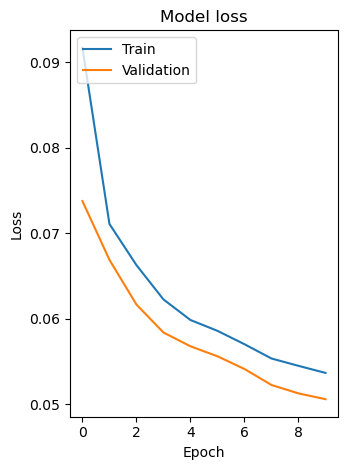

7844/7844 ━━━━━━━━━━━━━━━━━━━━ 7s 884us/step
latitude and longitude [[25.   25.   25.   ... 25.   25.   25.  ]
 [25.05 25.05 25.05 ... 25.05 25.05 25.05]
 [25.1  25.1  25.1  ... 25.1  25.1  25.1 ]
 ...
 [49.9  49.9  49.9  ... 49.9  49.9  49.9 ]
 [49.95 49.95 49.95 ... 49.95 49.95 49.95]
 [50.   50.   50.   ... 50.   50.   50.  ]] [[25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 ...
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]]
423.77246   409.89203


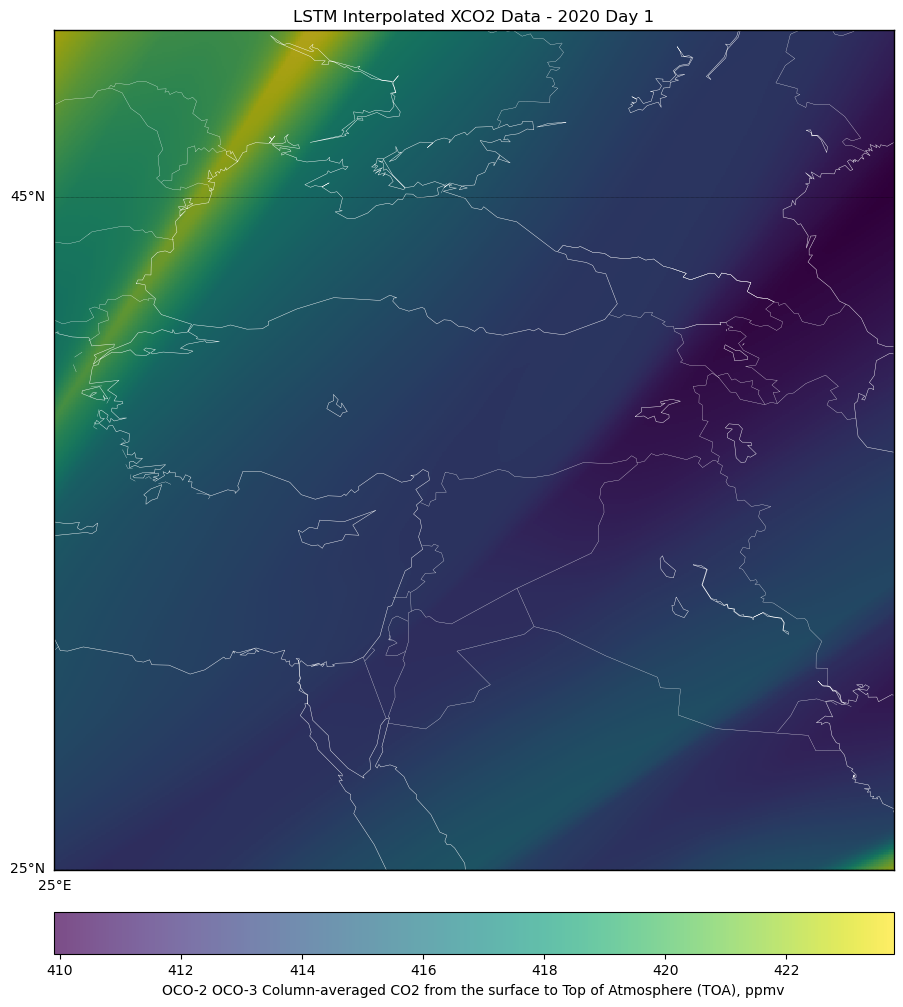

iam here
(501, 501) (501, 501)
dimension (501, 501)
(501, 501)
Epoch 1/10


C:\Users\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.3637 - mae: 0.5347 - val_loss: 0.1994 - val_mae: 0.3506 - learning_rate: 0.0050
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2793 - mae: 0.4498 - val_loss: 0.1527 - val_mae: 0.2777 - learning_rate: 0.0050
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2176 - mae: 0.3747 - val_loss: 0.1224 - val_mae: 0.2223 - learning_rate: 0.0050
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1781 - mae: 0.3172 - val_loss: 0.1041 - val_mae: 0.1876 - learning_rate: 0.0050
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1442 - mae: 0.2594 - val_loss: 0.0923 - val_mae: 0.1679 - learning_rate: 0.0050
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1219 - mae: 0.2188 - val_loss: 0.0854 - val_mae: 0.1562 - learning_rate: 0.0050
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1075 - mae: 0.1888 - val_loss: 0.0816 - val_mae: 0.1495 - learning_rate: 0.0050
Epoch 8/10
10/10 ━━━━━━━━━━━━━

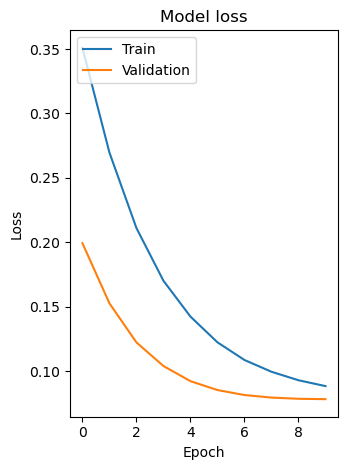

7844/7844 ━━━━━━━━━━━━━━━━━━━━ 7s 871us/step
latitude and longitude [[25.   25.   25.   ... 25.   25.   25.  ]
 [25.05 25.05 25.05 ... 25.05 25.05 25.05]
 [25.1  25.1  25.1  ... 25.1  25.1  25.1 ]
 ...
 [49.9  49.9  49.9  ... 49.9  49.9  49.9 ]
 [49.95 49.95 49.95 ... 49.95 49.95 49.95]
 [50.   50.   50.   ... 50.   50.   50.  ]] [[25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 ...
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]
 [25.   25.05 25.1  ... 49.9  49.95 50.  ]]
413.5674   412.72333


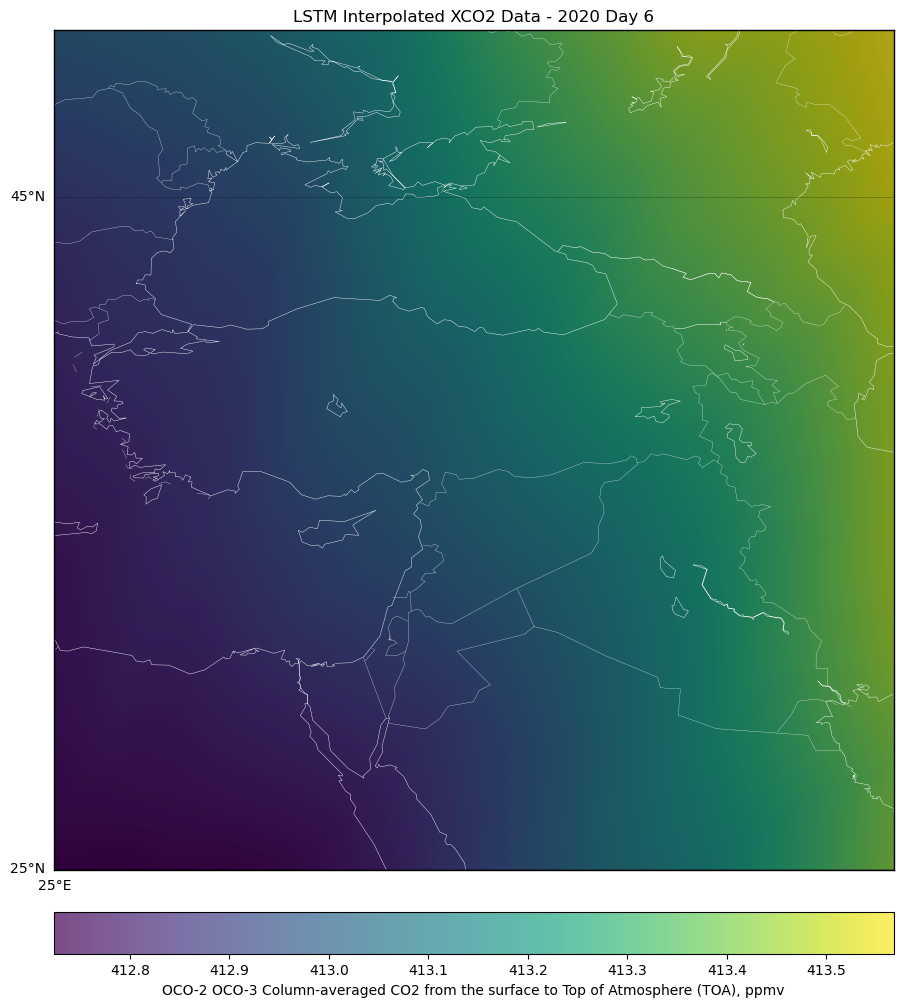

2
(2, 501, 501)
CPU times: total: 12.2 s
Wall time: 39.4 s


"obs_stat=readstations()\nverify(df1_list,obs_stat,save_directory,'CNN1D_LSTM')\nobs_stat=readstations()\nverify(df_list, obs_stat, save_directory1,'Grid')"

In [33]:
# for LSTM use the one below as first step without dates _ WORLD area study - Daily
%%time
import pandas as pd
import pandas as pd1
import pickle
time_series_b = []
version_str = 'B11100Ar'
file = ''
x_meas1 = []
'''latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180'''
latitude_max = 50
latitude_min = 25
longitude_max = 50
longitude_min =25
alldates= np.unique(arr2[:]['date'])
cnt=10 #len(alldates)
df_list = []
df1_list = []
P=5
inc=0
for j in range(0,cnt,P):
  print('iam here')
  x_meas1 = []
  '''latitude_max = 90
  latitude_min = -90
  longitude_max = 180
  longitude_min =-180'''
  latitude_max = 50
  latitude_min = 25
  longitude_max = 50
  longitude_min =25
  arr3=[]
  #for i in range(j,3):#j+1,1):
   #print("I am here near arr3",i)
  arr3.extend(arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))])
  #print(len(arr3))
  # Read the data from your variables

  latitude = np.array([row['Lat'] for row in arr3]) # Extract 'Lat' values into a numpy array
  longitude = np.array([row['Long'] for row in arr3]) # Extract 'Long' values into a numpy array
  x_meas = np.array([row['XCO2'] for row in arr3]) # Extra
  date= np.array([row['date'] for row in arr3]) # Extract 'date' values into a numpy array
  time = np.array([row['time'] for row in arr3]) # Extract 'time' values into a numpy array
  qf = np.array([row['Qual'] for row in arr3]) # Extract 'Qual' values into a numpy array
  # Apply the subset selection
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]
  # Apply the subset selection to data variables
  df1 = pd.DataFrame(time[selection_only], columns=['datetime_column'])
  # Extract the time
  df1['date_only'] = df1['datetime_column'].dt.date
  df1['time_only'] = df1['datetime_column'].dt.time
  #print(df1['date_only'])
  df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
  #print(np.sum(df1['seconds']))
  points= np.zeros((len(selection_only),4)).astype(np.float32)
  points[:,0] = date[selection_only]
  points[:,1] = longitude[selection_only]
  points[:,2] = latitude[selection_only]
  points[:,3] = x_meas[selection_only]
  #print(points.shape)
  #print(points[:,0].shape,points[:,1].shape)
 #regress_DL(points[:,0:4],points[:,4])
  pixel_size_deg =0.05 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  print(grid_lat.shape,grid_lon.shape)
  dimen = grid_lat.shape
  print("dimension",dimen)
  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((points[:,2], points[:,1]), points[:,3], (grid_lat, grid_lon), method='linear')#  rescale=True)
  print(grid_x.shape)
  # Create a list of dataframes
  df = pd.DataFrame({
      #'date': df1['date_only'],
      #'time': df1['time_only'],
      'latitude':  grid_lat.flatten(),
      'longitude': grid_lon.flatten(),
      'xco2': grid_x.flatten(),
     # 'date': j,
      'shape1':dimen[0],
      'shape2':dimen[1]
  })
  df_list.append(df)
  df1_list.append(predict_daily(df,j))
  time_series_b.append(grid_x)
print(len(df_list))
time_series_b = np.array(time_series_b)
print(time_series_b.shape)
x_meas_month_mean_a = np.mean(time_series_b, axis=0)
#regress_DL2(df_list)
save_directory = './World2020_1_4_lstm__'
save_directory1 = './World2020_1_4_grid__'
# Suppose your list is called df_list
with open('./df1_list.pkl', 'wb') as f:
    pickle.dump(df1_list, f)
'''obs_stat=readstations()
verify(df1_list,obs_stat,save_directory,'CNN1D_LSTM')
obs_stat=readstations()
verify(df_list, obs_stat, save_directory1,'Grid')'''

In [36]:
!pip install rasterio

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.4 MB 1.3 MB/s eta 0:00:20
   ---------------------------------------- 0.0/25.4 MB 487.6 kB/s eta 0:00:53
   ---------------------------------------- 0.1/25.4 MB 819.2 kB/s eta 0:00:31
   ---------------------------------------- 0.1/25.4 MB 819.2 kB/s eta 0:00:31
   ---------------------------------------- 0.2/25.4 MB 756.6 kB/s eta 0:00:34
   ---------------------------------------- 0.2/25.4 MB 778.2 kB/s eta 0:00:33
   ---------------------------------------- 0.2/25.4 MB 835.2 kB/s eta 0:00:31
   ---------------------------------------- 0.3/25.4 MB 774.0 kB/s eta 0:00:33
    --------------------------------------- 0.3/25.4 MB 811.9 kB/s eta 0:00:31
    --------------------------------------- 0.4/25.4 MB 818.3 kB/s eta 0:00:31
    --------------------------------------- 0.4/25.4 MB 844.5 kB/s eta 0:00:30
    --------------------------------------- 0.4/25.4 MB 808.4 k

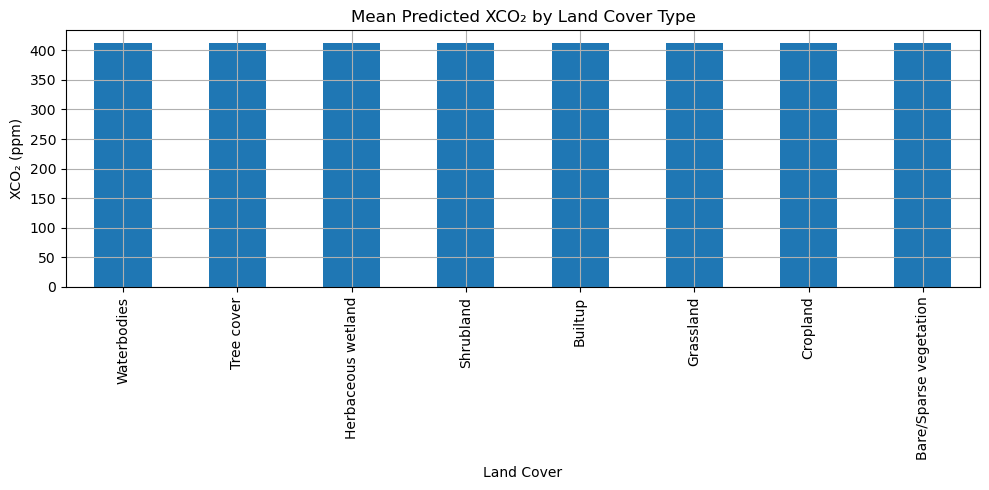

In [40]:
# for predicting CO2 point of emission
import rasterio
from rasterio.transform import from_origin
from rasterio.features import geometry_mask
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
with open('./df1_list.pkl', 'rb') as f:
    df1_list_loaded = pickle.load(f)
# Load the land cover TIFF
land_cover_path = "C:/Users/Dr. Mohamad Awad/Downloads/Sentinel_2_land_cover.tif"
src = rasterio.open(land_cover_path)
land_cover = src.read(1)  # Read the first band
transform = src.transform

# Function to get land cover class at given coordinates
def get_land_cover_at_coords(lon, lat):
    col, row = ~transform * (lon, lat)  # Convert to raster indices
    col, row = int(col), int(row)
    if (0 <= row < land_cover.shape[0]) and (0 <= col < land_cover.shape[1]):
        return land_cover[row, col]
    else:
        return np.nan

# Map land cover classes to human-readable labels (modify this to match your legend)
land_cover_labels = {
    10: 'Tree cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Builtup',
    60: 'Bare/Sparse vegetation',
    70: 'Snow and ice',
    80: 'Waterbodies',
    90: 'Herbaceous wetland',
    95: 'Mangroves',
    100: 'Moss and lichen'
}

# Initialize container
all_data = []

# Loop through your list of predicted DataFrames
for df in df1_list:
    df = df.copy()
    df['land_cover_class'] = df.apply(lambda row: get_land_cover_at_coords(row['longitude'], row['latitude']), axis=1)
    df['land_cover_label'] = df['land_cover_class'].map(land_cover_labels)
    all_data.append(df)

# Concatenate into a single DataFrame
merged_df = pd.concat(all_data, ignore_index=True)

# Drop rows with no land cover match
merged_df = merged_df.dropna(subset=['land_cover_label'])

# Analyze: Mean XCO2 by land cover class
mean_xco2_per_class = merged_df.groupby('land_cover_label')['xco2'].mean().sort_values(ascending=False)

# Plot the result
mean_xco2_per_class.plot(kind='bar', figsize=(10,5), title='Mean Predicted XCO₂ by Land Cover Type')
plt.ylabel('XCO₂ (ppm)')
plt.xlabel('Land Cover')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

time_series_b = []
version_str = 'B11100Ar'
x_meas1 = []
latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min = -180

# Assuming arr2 is a numpy ndarray, convert it to a pandas DataFrame
arr2 = pd.DataFrame(arr2, columns=['date', 'time', 'Lat', 'Long', 'XCO2', 'Qual'])
# Converting 'date' and 'time' columns to datetime format
arr2['date'] = pd.to_datetime(arr2['date'], format='%Y%m%d')
arr2['time'] = pd.to_datetime(arr2['time'], format='%H:%M:%S')
arr2['month'] = arr2['date'].dt.month
#print(arr2)
# Combine 'date' and 'time' into a single datetime column
#arr2['datetime'] = arr2.apply(lambda row: pd.Timestamp.combine(row['date'], row['time']), axis=1)

# Adding a 'month' column to the dataframe for aggregation
#arr2['month'] = arr2['datetime'].dt.month
#print(arr2['month'])
arr2 = arr2[arr2['month'].isin([1, 2])]
# Grouping data by month
monthly_data = arr2.groupby('month').apply(lambda x: x).reset_index(drop=True)
print(monthly_data.head())

df_list = []
df1_list = []
time_series_b = []
j=0
for month in monthly_data['month'].unique():
    month_data = monthly_data[monthly_data['month'] == month]
    latitude = month_data['Lat'].to_numpy()
    longitude = month_data['Long'].to_numpy()
    x_meas = month_data['XCO2'].to_numpy()
    date = month_data['date'].to_numpy()
    datetime = month_data['time'].to_numpy()
    qf = month_data['Qual'].to_numpy()
    monthly = month_data['month'].to_numpy()

    # Apply the subset selection
    selection_only = np.where(
        (latitude > latitude_min) & (latitude < latitude_max) &
        (longitude > longitude_min) & (longitude < longitude_max) & (qf == 0)
    )[0]
    df1 = pd.DataFrame(datetime[selection_only], columns=['datetime_column'])
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time
    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()

    points = np.zeros((len(selection_only), 5)).astype(np.float32)
    points[:, 0] = date[selection_only]
    points[:, 1] = longitude[selection_only]
    points[:, 2] = latitude[selection_only]
    points[:, 3] = x_meas[selection_only]
    points[:, 4] = monthly[selection_only]
    print(points)
    pixel_size_deg = 1.0  # 5x5 degree grid resolution
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    dimen = grid_lat.shape

    grid_x = griddata((points[:, 2], points[:, 1]), points[:, 3], (grid_lat, grid_lon), method='linear', rescale=True)

    df = pd.DataFrame({
        'latitude': grid_lat.flatten(),
        'longitude':grid_lon.flatten(),
        'xco2': grid_x.flatten(),
        'shape1': dimen[0],
        'shape2': dimen[1]
    })

    df_list.append(df)
    df1_list.append(predict_daily(df,j))
    time_series_b.append(grid_x)
    j=j+1
print(len(df_list))
print(df_list)
save_directory = './World2020_1_4_grid/'
save_directory1 = './World2020_1_4_lstm_/'
print(df1_list)
#obs_stat = readstations()
verify(df1_list, obs_stat, save_directory1,'monthly')
#verify(df_list, obs_stat, save_directory,'monthly')
#obs_stat = readstations()

In [28]:
# Second step to run without dates LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.regularizers import l2
# Assuming dataframes are combined into a single DataFrame 'df'
# df = pd.concat(list_of_dataframes)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def denormalize(scaler, values):
    return scaler.inverse_transform(values)
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true)) + 0.01 * tf.reduce_sum(tf.abs(y_pred))
def calculate_accuracy(y_true, y_pred):
    # Convert to binary classification for accuracy calculation
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)
    return accuracy_score(y_true_binary, y_pred_binary)
dpi = 300;
def plot_training_history(history,scaler, X_test, y_test, X_train, y_train, save_dir,day,model):
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
    # Plot training & validation accuracy values
    '''if 'accuracy' in history.history and 'val_accuracy' in history.history:
        train_accuracy = (0.001 - np.array(history.history['accuracy'])) * 100
        val_accuracy = (0.001 - np.array(history.history['val_accuracy'])) * 100
        print(" Accuracy train :", train_accuracy, "Validation: ", val_accuracy)
        # Denormalize the predicted and true values
        y_pred = model.predict(X_test)
        y_pred_denorm = denormalize(scaler, y_pred)
        y_test_denorm = denormalize(scaler, y_test)
        # Calculate accuracy on denormalized values
        accuracy_test = calculate_accuracy(y_test_denorm, y_pred_denorm)
        print("Real Test Accuracy: {:.2f}%".format(accuracy_test * 100))
        y_pred = model.predict(X_train)
        y_pred_denorm = denormalize(scaler, y_pred)
        y_train_denorm = denormalize(scaler, y_train)
        # Calculate accuracy on denormalized values
        accuracy = calculate_accuracy(y_train_denorm, y_pred_denorm)
        print("Real train Accuracy: {:.2f}%".format(accuracy * 100))
        plt.subplot(1, 2, 1)
        plt.plot(train_accuracy)
        plt.plot(val_accuracy)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Epoch')
        plt.ylim([99.90, 100.00])
        plt.legend(['Train', 'validation'], loc='upper left')
        plt.savefig(os.path.join(save_dir, 'model_accuracy.png'))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')'''
    if 'loss' in history.history and 'val_loss' in history.history:
        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, '{day+1}_mcobined_plots.png'))
    plt.savefig(f'{save_dir}{day+1}_2020_combined_plots.png', dpi=dpi)
    plt.show()



def predict_daily(df_list,daytime):
  #df_combined = pd.concat(df_list, ignore_index=True)
  df_combined = df_list
  scaler = MinMaxScaler()
  #df_combined[[ 'xco2']] = scaler.fit_transform(df_combined[[ 'xco2']])
  # Prepare input and output
  X = df_combined[[ 'latitude','longitude']].values
  y = df_combined['xco2'].values
  nan_indices = np.isnan(y)
  #y = np.nan_to_num(y, nan=0)
  #daytime = df_combined['date'].values
  dimen1 = df_combined['shape1'].values
  dimen2 = df_combined['shape2'].values
  # Reshape input for CNN+LSTM [samples, timesteps, features]
  #X_scaled = scaler.fit_transform(X)
  y_scaled = scaler.fit_transform(y.reshape(-1, 1))
  #X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
  X_scaled = X.reshape((X.shape[0], 1, X.shape[1]))
  #X = X.reshape((X.shape[0], 1, X.shape[1]))'''
  #X = X.reshape((X.shape[0], 1, X.shape[1]))
  #print(X.shape)
  #print("scaled")
  #print(X_scaled[:5] )
  #print(me)
  #print(y_scaled)
  # Split data into training and testing sets
  # Train-test split
  '''nan_indices = np.isnan(y) # Extract the elements of X where y values are NaN
  X_test = X_scaled[nan_indices]
  y_test = y_scaled[nan_indices]
  print("I am nwae = ", y_test)
  y_test = np.nan_to_num(y_test, nan=0.0)
  print(y_test)
  X_train = X_scaled[~nan_indices]
  y_train = y_scaled[~nan_indices]

  y_test = np.nan_to_num(y_test, nan=0.0)
  print(y_test)'''
  X_test1 = X_scaled[nan_indices]
  X_scaled1 = X_scaled[~nan_indices]
  y_scaled1 = y_scaled[~nan_indices]
  #y_test1 = y_scaled[nan_indices]
  # X_test1 = X_test1.reshape(X_test1.shape[0], 1, X_test1.shape[1])
  X_train, X_test, y_train, y_test = train_test_split(X_scaled1,y_scaled1, test_size=0.25, random_state=42)
  #X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  #print("before training the model", X_train)
  #print(pd('star'))
  # Build CNN+LSTM model
  # Predict
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=1))
  model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=1))
  model.add(LSTM(50, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dense(1))

  model.compile(optimizer=SGD(learning_rate=0.005),
                loss='mse',metrics=['mae'])
  callbacks = [
      EarlyStopping(monitor='val_loss', patience=10, verbose=1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1) #,
      #ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
  ]
  history = model.fit(X_train, y_train,
                      epochs=10,
                      batch_size=64,
                      validation_data=(X_test, y_test),
                      callbacks=callbacks,
                      verbose=1)

  '''model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(MaxPooling1D(pool_size=1))
  model.add(LSTM(50, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))  # Adding Dropout layer
  model.add(LSTM(50, activation='relu'))
  model.add(Dropout(0.2))  # Adding Dropout layer
  model.add(Dense(1))

  # Add L2 regularization

  model.add(Dense(1, kernel_regularizer=l2(0.01)))

  model.compile(optimizer=SGD(learning_rate=0.0005),loss=custom_loss,metrics=['mse'])#loss=custom_loss,metrics=['mae'])# loss='mse',metrics=['accuracy'])

  plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, verbose=1, mode='min', baseline=0.05)'''
  #history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=callbacks)
  # Assuming you have your model history stored in 'history'
  save_directory = './World2020_1_4_lstm__/'
  plot_training_history(history,scaler, X_test, y_test, X_train, y_train,save_directory,daytime,model)
  #y_pred = model.predict(X_test1)
  #df1=display_results(y_pred, y_scaled,X_scaled,nan_indices ,scaler, dimen1, dimen2, daytime)
  y_pred = model.predict(X_scaled)
  df1=display_results(y_pred, X_scaled,scaler, dimen1, dimen2, daytime)
  #print("here is df", df1)
  #.reshape(-1, 1)
  #reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
  return df1

In [30]:
#Part of LSTM WORLD area study
'''latitude_max = 90
latitude_min = -90
longitude_max = 180
longitude_min =-180'''
latitude_max = 50
latitude_min = 25
longitude_max = 50
longitude_min =25
from datetime import datetime

aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio
current_date = datetime.strptime("2020", "%Y")
# Specify figure size (in inches)
dpi = 300;
import pandas as pd
def display_results(y_pred, X_scaled,scaler, dimen1, dimen2,daytime):
  y_pred_inv = scaler.inverse_transform(y_pred)
  y_pred_inv= y_pred_inv.reshape(-1, 1)
  #print("after prediction : ",np.min(y_pred_inv), " Maximum ", np.max(y_pred_inv))
  #print(me)
  X_scaled_2D = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[2]) # Reshape to (samples, features)
  #X_scaled_inv = scaler.inverse_transform(X_scaled_2D) # Apply inverse_transform to the reshaped 2D array
  y_scaled_inv_re = y_pred_inv.reshape(dimen)
  grid_lat= X_scaled_2D[:,0].reshape(dimen)
  grid_lon= X_scaled_2D[:,1].reshape(dimen)
  df = pd.DataFrame({
      #'date': df1['date_only'],
      #'time': df1['time_only'],
      'latitude':  grid_lat.flatten(),
      'longitude': grid_lon.flatten(),
      'xco2':y_scaled_inv_re.flatten(),
      'date': daytime,
      'shape1':dimen1,
      'shape2':dimen2
  })
  print("latitude and longitude",grid_lat,grid_lon)
  plt.figure(figsize=(w / dpi, h / dpi))
# Create a basemap instance
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)

  pixel_size_deg =0.05 # 5 degree resolution

  # Get the grid for the interpolated values
  vmax1=np.max(y_pred_inv)  # Apply the mask to the slice
  vmin1= np.min(y_pred_inv)  # Apply the mask to the slice
  print(vmax1," ",vmin1)
  # Plot the interpolated data using pcolormesh instead of scatter
  m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
  cmap = plt.get_cmap('viridis')
  sc = m.pcolormesh(  grid_lon, grid_lat, y_scaled_inv_re, latlon=True, cmap=cmap, alpha=0.7, vmin=vmin1, vmax=vmax1, shading='auto')
  #m.scatter(longitude,latitude,c =x_meas,s = 5,cmap = 'Greys')
  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="5%")
  cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
  month_names = ["January", "February", "March", "April", "May", "June",
      "July", "August", "September", "October", "November", "December"
  ]
  # set plot title
  title_date = current_date #.strftime("%b-%Y")
  #plt.title(f'OCO-2 OCO-3 Column-averaged CO2 Monthly Average for july 2023')
  plt.title(f'LSTM Interpolated XCO2 Data - 2020 Day {daytime+1}') # month {month_names[daytime]}')
  #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')
  # List of month names (index 0 is empty to align with month numbers 1-12)

  # Save figure to PNG file
  #plt.savefig(f'./DINEOF_2020_2023_45_90/oco2_oco3_co2_month_average_july_2023_LSTMinter.png', dpi=dpi, bbox_inches='tight')
  #plt.savefig(f'./World2020_1_4_lstm/{month_names[daytime]}_2020_LSTMinter.png', dpi=dpi, bbox_inches='tight')
  plt.savefig(f'./World2020_1_4_lstm__/{daytime+1}_2020_LSTMinter.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()
  return df

In [ ]:
#specific area of study and create file for DINEOF
time_series_d = []
version_str = 'B11100Ar'
file = ''
df_list= []
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
'''latitude_max = 50.0
latitude_min = 0.0
longitude_max = 60.0
longitude_min = -10.0'''
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
print(alldates)
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
    X= np.zeros((len(arr3),4)).astype(np.float32)
    # Read the data from your variables
    # Slice X based on the current indices of arr3 in arr2
    #indices = np.where(arr2[:]['date'] == np.datetime64((alldates[j])))[0]
    print(arr3[:])
    X[:,0] = arr3[:]['Lat']
    X[:,1] =arr3[:]['Long']
    X[:,2] =arr3[:]['XCO2']

    df1 = pd.DataFrame(arr3['time'], columns=['datetime_column'])

    # Extract the time
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time

    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
    X[:,3] = df1['seconds']
    print(X.size)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
    selection_only = np.where(
      (X[:,0] > latitude_min) & (X[:,0] < latitude_max) &
      (X[:,1] > longitude_min) &(X[:,1] < longitude_max))[0]
    print('this is the selection',len(selection_only))
    # Apply the subset selection to data variables
    X1= np.zeros((len(selection_only),4)).astype(np.float32)
    #Y1= np.zeros((len(selection_only))).astype(np.float32)
    X1[:,:] = X[selection_only,:]

  # Apply the subset selection to data variables
    pixel_size_deg =0.5 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
    time_series_d.append(grid_x)
    dimen = grid_lat.shape
    print("dimension",dimen)
    # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    df1 = pd.DataFrame({
        #'date': df1['date_only'],
        #'time': df1['time_only'],
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
    df_list.append(df1)
lat1 = np.linspace(-22, 68, grid_x.shape[0])  # 2D latitude array
lon1 = np.linspace(-22, 68, grid_x.shape[1])  # 2D longitude array
time = np.arange(0, 31)  # 1D time array (e.g., periods of the july month)
filename="co2march2023a.nc"
time_series_d= np.array(time_series_d)
create_netcdf2(time,lat1,lon1, time_series_d, filename)
print(time_series_d.shape)
#obs_stat=readstations()
#verify(df_list,obs_stat)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.basemap import Basemap
import os
import netCDF4 as nc
import pandas as pd

# Load the data
df_list = []
file_path = "C:/shared/dineof_OCO_2_3_july_2020a.nc"
dataset = nc.Dataset(file_path, 'r')
data = dataset.variables['xco2'][:]
x_interpolated = data
assert time_series_d.shape == x_interpolated.shape, "Shape mismatch between original and interpolated data"
save_dir = "C:/Users/Dr. Mohamad Awad/interp_orig_xco2_2020_2023/july2020aa/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Calculate error metrics for each day, excluding NaN values
mae_list = []
rmse_list = []
original_data = time_series_d
interpolated_data = x_interpolated

# Write RMSE and MAE values to a text file
with open(os.path.join(save_dir, "error_metrics.txt"), "w") as file:
    file.write("Day\tMAE\tRMSE\n")
    for day in range(31):
        mask = ~np.isnan(original_data[day])
        mae = mean_absolute_error(original_data[day][mask], interpolated_data[day][mask])
        rmse = np.sqrt(mean_squared_error(original_data[day][mask], interpolated_data[day][mask]))
        mae_list.append(mae)
        rmse_list.append(rmse)
        file.write(f"{day+1}\t{mae:.4f}\t{rmse:.4f}\n")

# Save error metrics plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), mae_list, label='MAE', marker='o')
plt.plot(range(1, 32), rmse_list, label='RMSE', marker='x')
plt.xlabel('Day')
plt.ylabel('Error')
plt.title('Error Metrics Over 31 Days')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2)
plt.grid(False)
plt.savefig(os.path.join(save_dir, 'error_metrics_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Define your latitude and longitude limits
latitude_min, latitude_max = -22, 68
longitude_min, longitude_max = -22, 68

# Plotting data
for day in range(31):
    pixel_size_deg = 0.5  # Ensure you define pixel_size_deg somewhere before this loop
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    dimen = grid_lat.shape
    print("dimension", dimen)

    df1 = pd.DataFrame({
        'latitude': grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': x_interpolated[day].flatten(),
        'date': day,
        'shape1': dimen[0],
        'shape2': dimen[1]
    })
    df_list.append(df1)

    # Create map plot for original data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, original_data[day], latlon=True, cmap='jet', alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data July 2020 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'original_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Create map plot for interpolated data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, x_interpolated[day], latlon=True, cmap='jet', alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Interpolated XCO2 Data July 2020 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'interpolation_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Scatter plot for each day
    vmin, vmax = np.nanmin(original_data[day]), np.nanmax(interpolated_data[day])
    plt.figure(figsize=(8, 8))
    plt.scatter(original_data[day][mask], interpolated_data[day][mask], alpha=0.3, c='blue', s=10)
    plt.plot([vmin, vmax], [vmin, vmax], 'r--')
    plt.xlabel('Original XCO2 Data')
    plt.ylabel('Interpolated XCO2 Data')
    plt.title(f'Comparison of Original and Interpolated XCO2 Data - July 2020 Day {day+1}')
    plt.grid(False)
    plt.savefig(os.path.join(save_dir, f'scatter_plot_day_{day+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Assuming you have functions readstations() and verify() defined elsewhere
obs_stat = readstations()
verify(df_list, obs_stat)


In [ ]:
# a modified DINEOF display results that changed RMSE and MAE to Error and number of stations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
import netCDF4 as nc
import pandas as pd

# Load the data
df_list = []
file_path = "C:/shared/dineof_OCO_2_3_march_2023a.nc"
save_directory = "C:/Users/Dr. Mohamad Awad/interp_orig_xco2_2020_2023/march2023aa/"
dataset = nc.Dataset(file_path, 'r')
data = dataset.variables['xco2'][:]
x_interpolated = data
#assert time_series_d.shape == x_interpolated.shape, "Shape mismatch between original and interpolated data"

save_dir = "C:/Users/Dr. Mohamad Awad/interp_orig_xco2_2020_2023/march2023aa/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Calculate error metrics for each day, excluding NaN values
error_list = []
avg_error_list = []
num_stations_list = []

original_data = time_series_d
interpolated_data = x_interpolated

# Write error values to a text file
with open(os.path.join(save_dir, "error_metrics.txt"), "w") as file:
    file.write("Day\tError\tAverage Error\tNumber of Stations\n")
    for day in range(31):
        mask = ~np.isnan(original_data[day])
        error = np.abs(original_data[day][mask] - interpolated_data[day][mask])
        avg_error = np.mean(error)
        num_stations = np.sum(mask)

        error_list.append(error)
        avg_error_list.append(avg_error)
        num_stations_list.append(num_stations)

        file.write(f"{day+1}\t{error.mean():.4f}\t{avg_error:.4f}\t{num_stations}\n")

# Save error metrics plot with vivid colors and custom spacing
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), avg_error_list, label='Average Error', marker='o', color='blue', linestyle='-', linewidth=2)
plt.xlabel('Day')
plt.ylabel('Average Error')
plt.title('Average Error Over 31 Days')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2)
plt.grid(False)
plt.savefig(os.path.join(save_dir, 'average_error_plot.png'), dpi=300, bbox_inches='tight', pad_inches=5)  # Set the pad_inches to 5
plt.show()

# Define your latitude and longitude limits
latitude_min, latitude_max = -22, 68
longitude_min, longitude_max = -22, 68

# Plotting data for each day
for day in range(31):
    pixel_size_deg = 0.5  # Ensure you define pixel_size_deg somewhere before this loop
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg,
                                  longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    dimen = grid_lat.shape

    df1 = pd.DataFrame({
        'latitude': grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': x_interpolated[day].flatten(),
        'date': day,
        'shape1': dimen[0],
        'shape2': dimen[1]
    })

    df_list.append(df1)

    # Create map plot for original data with vivid colors
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    cmap = plt.get_cmap('viridis')# or 'jet'
    sc = m.pcolormesh(grid_lon, grid_lat, original_data[day], latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data March 2023 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'original_day_{day+1}.png'), dpi=300, bbox_inches='tight', pad_inches=5)  # Set the pad_inches to 5
    plt.show()
    plt.close()

    # Create map plot for interpolated data with vivid colors
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    cmap = plt.get_cmap('viridis')# or 'jet'
    sc = m.pcolormesh(grid_lon, grid_lat, x_interpolated[day], latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Interpolated XCO2 Data March 2023 - Day {day+1}')
    plt.savefig(os.path.join(save_dir, f'interpolation_day_{day+1}.png'), dpi=300, bbox_inches='tight', pad_inches=5)  # Set the pad_inches to 5
    plt.show()
    plt.close()

    # Scatter plot for each day with vivid colors
    plt.figure(figsize=(8, 8))
    plt.scatter(original_data[day][mask], interpolated_data[day][mask], alpha=0.7, c='blue', s=10)
    vmin, vmax = np.nanmin(original_data[day]), np.nanmax(interpolated_data[day])
    plt.plot([vmin, vmax], [vmin, vmax], 'r--')
    plt.xlabel('Original XCO2 Data')
    plt.ylabel('Interpolated XCO2 Data')
    plt.title(f'Comparison of Original and Interpolated XCO2 Data - March 2023 Day {day+1}')
    plt.grid(False)
    plt.savefig(os.path.join(save_dir, f'scatter_plot_day_{day+1}.png'), dpi=300, bbox_inches='tight', pad_inches=5)  # Set the pad_inches to 5
    plt.show()
    plt.close()

# Assuming you have functions readstations() and verify() defined elsewhere
obs_stat = readstations1()
verify(df_list, obs_stat,save_directory)


In [ ]:
print(len(lat), len(lon))

In [ ]:
arr2['Id'] = data1[:, 0].astype(np.int32)
arr2['date'] = data1[:, 1]
arr2['time'] = data1[:, 2]
arr2['XCO2'] = data1[:, 3]
arr2['Long'] = data1[:, 4]
arr2['Lat'] = data1[:, 5]
arr2['Qual'] = data1[:, 6].astype(np.int32)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def pointIntgrid(points,grid_values, grid_size):
  lat_min = np.min(points[:,0])
  lat_max = np.max(points[:,0])
  lon_min = np.min(points[:,1])
  lon_max = np.max(points[:,1])
  newpoints= np.zeros((len(points),3)).astype(np.float32)
  for i in range (len(points)):
    point = points[i,:]
    lat_idx = int((point[0] - lat_min) // grid_size)
    lon_idx = int((point[1] - lon_min) // grid_size)
    cell_value = grid_values[lat_idx, lon_idx]
    newpoints[i,0] = point[0]
    newpoints[i,1] = point[1]
    newpoints[i,2] = cell_value
    #print(f"Point {point} is in grid cell ({lat_idx}, {lon_idx}) with value {cell_value}")

  # Plot the second array of points
  '''plt.scatter(points[:, 1], points[:, 0], c=points[:,2], cmap='Reds', label='original', edgecolor='black')
  plt.scatter(newpoints[:, 1], newpoints[:, 0], c=newpoints[:,2], cmap='Blues', label='Griddata interp', edgecolor='black')

  # Add colorbars
  plt.colorbar(label='Values of original data', orientation='vertical', pad=0.01, aspect=10)
  plt.colorbar(label='Values of interpolation by grid data', orientation='vertical', pad=0.01, aspect=10)

  # Add labels and legend
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Plotting Values of original plus interpolated')
  plt.legend()

  # Show the plot
  plt.show()'''
  print(len(points))
  print(np.count_nonzero(np.isnan(points[:, 2])))
  original_values = points[:, 2]
  print(np.count_nonzero(np.isnan(newpoints[:, 2])))
  predicted_values = newpoints[:, 2]
  mask = ~np.isnan(predicted_values)
  filtered_original = original_values[mask]
  filtered_predicted = predicted_values[mask]

  # Calculate R-squared value
  r2 = r2_score(filtered_original, filtered_predicted)
  print(f"R-squared value: {r2}")
  # Plot the original data points
  ''' plt.scatter(points[:, 1], points[:, 0], c=points[:,2], cmap='Blues', label='Original', edgecolor='black')

  # Plot the predicted data points
  plt.scatter(newpoints[:, 1], newpoints[:, 0], c=newpoints[:,2], cmap='Reds', label='Predicted', edgecolor='black')

  # Add colorbars
  plt.colorbar(label='Values (Original)', orientation='vertical', pad=0.01, aspect=10)
  plt.colorbar(label='Values (Interpolated by DINEOF)', orientation='vertical', pad=0.01, aspect=10)

  # Add labels and legend
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Original vs Predicted Data with R-squared')
  plt.legend()

  # Show the plot
  plt.show()'''
  plt.scatter(original_values, predicted_values, color='blue', s=10,label='Original vs RBF interpolation')

  # Plot a line y=x for reference
  plt.plot([min(original_values), max(original_values)], [min(original_values), max(original_values)], color='red', linestyle='--', label='y=x')

  # Add labels and legend
  plt.xlabel('Original Values')
  plt.ylabel('RBF interpolated Values')
  plt.title('Original vs RBF interpolated Values with R-squared')
  plt.legend()

  # Show the plot
  plt.show()


In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
# This is the correct RBFinterpolator - Use here please
%%time

from scipy.interpolate import RBFInterpolator, Rbf, CloughTocher2DInterpolator,LinearNDInterpolator,RegularGridInterpolator,NearestNDInterpolator,make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
#import datetime
from timeit import default_timer as timer
start = timer()
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
a = 0.1
# Get the colormap colors, multiply them with the factor "a", and create new colormap
my_cmap = plt.cm.jet(np.arange(plt.cm.jet.N))
my_cmap[:,0:3] *= a
my_cmap = ListedColormap(my_cmap)
alldates= np.unique(arr2[:]['date'])
#print(len(alldates))
df_list=[]
for j in range(len(alldates)):
  aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
  w = 3600; h = w / aspect_ratio
  dpi = 300;
  plt.figure(figsize=(w / dpi, h / dpi))
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
      X= np.zeros((len(arr3),3)).astype(np.float32)
      Y= np.zeros((len(arr3))).astype(np.float32)
      qf= np.zeros((len(arr3))).astype(np.int32)
      X[:,0] = arr3[:]['Lat']
      X[:,1] =arr3[:]['Long']
      X[:,2] =arr3[:]['XCO2']
      qf[:] = arr3[:]['Qual']
      print(X.shape)
      #print(Y.shape)
      selection_only = np.where((X[:,0] > latitude_min) & (X[:,0] < latitude_max) & (X[:,1] > longitude_min) &(X[:,1] < longitude_max) )[0]
      print("length of selection", len(selection_only))
      # Apply the subset selection to data variables
      X1= np.zeros((len(selection_only),3)).astype(np.float32)
      #Y1= np.zeros((len(selection_only))).astype(np.float32)
      X1[:,:] = X[selection_only,:]
      points= np.zeros((len(selection_only),3)).astype(np.float32)
      points[:,0] = X[selection_only,0]
      points[:,1] = X[selection_only,1]
      points[:,2] = X[selection_only,2]
  pixel_size_deg =0.5 # 5x5 degree grid resolution
  num_lat_points = int(np.round((latitude_max - latitude_min) / pixel_size_deg,0)) + 1
  num_lon_points = int(np.round((longitude_max - longitude_min) / pixel_size_deg))+ 1
  print(num_lat_points)
  print(num_lon_points)
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg,
                   longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)
  nan_mask = np.isnan(grid_x)
  nan_coords = np.array([grid_lon[nan_mask], grid_lat[nan_mask]]).T
  #xflat = xgrid.reshape(2, -1).T
  print("grid_x size:", grid_x.shape)
  lat_1d =X1[:,0].ravel()
  lon_1d =X1[:,1].ravel()
  #lat_1d =grid_lat.ravel()
  #lon_1d =grid_lon.ravel()
  # Stack them to create the input for RBFInterpolator
  #y = np.stack([grid_lat_1d, grid_lon_1d], axis=-1)
  y = np.stack([lat_1d, lon_1d], axis=-1)
  print("y shape:",y.shape)
  #grid_x = np.nan_to_num(grid_x).astype(np.float32)
  #print("grid values:",grid_x.ravel())
  vmax1=np.max(X1[:,2])
  vmin1= np.min(X1[:,2])
  print("grid max",vmax1)
  print("grid min",vmin1)
  #vmax1=np.max(grid_x)
  #vmin1= np.min(grid_x)
  #print(vmax1)
  #print(vmin1)
  #yflat = RBFInterpolator(y,grid_x.ravel(), kernel='linear')
  rbf = RBFInterpolator(y,X1[:,2].ravel(), kernel='linear',neighbors=2, smoothing=0.1)
  #interpolated_values = yflat(np.stack([grid_lat.ravel(), grid_lon.ravel()], axis=-1))
  #interpolated_values = interpolated_values.reshape(grid_lat.shape)  # Reshape to match grid
  #interpolated_values = yflat(np.stack([lat.ravel(), lon.ravel()], axis=-1))
  #interpolated_values = interpolated_values.reshape(lat.shape)  # Reshape to match grid
  print("I finished running RBFInterpolator")
  interpolated_values = rbf(nan_coords)
  # Replace NaN values with interpolated values from RBFInterpolator
  grid_x[nan_mask] = interpolated_values
  #ax.pcolormesh(*xgrid, ygrid, vmin=-380, vmax=430, shading='gouraud')
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
  # Perform RBF interpolation
  #yflat = RBFInterpolator(y,grid_x.ravel(), kernel='linear')

  #p = ax.scatter(*X.T, c=Y, s=50, ec='k', vmin=-380, vmax=430)
  #fig.colorbar(p)
  #plt.show()
  vmax1=np.max(grid_x)
  vmin1= np.min(grid_x)
  print("interpolated max: ", vmax1)
  print("interpolated min: ", vmin1)
  #sc = m.pcolormesh(grid_lat, grid_lon,interpolated_values[:-1,:-1], latlon=True,cmap= my_cmap,vmin=vmin1, vmax=vmax1,shading='flat')#shading='gouraud')#grid_lon, grid_lat, time_series_d[i,:-1,:-1], latlon=True, cmap='jet', alpha=0.9,vmin=vmin1, vmax=vmax1, shading='flat')
  cmap = plt.get_cmap('viridis') #cmap = plt.get_cmap('coolwarm')
  # Use pcolormesh to plot the data
  sc = m.pcolormesh(grid_lon, grid_lat, grid_x[:-1, :-1], latlon=True, cmap=cmap, vmin=vmin1, vmax=vmax1, shading='flat',alpha=0.7)
  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="5%")
  #cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  #cbar.set_label('OCO-2-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppm')
  current_date= alldates[j]
  title_day = "OCO-2-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppm " + str(current_date)
  plt.title(title_day)
  # Show the plot
  savedir='./data_image_rbfjuly2023/'
  plt.savefig(f"./data_image_rbfjuly2023/"+"RBF_"+ str(current_date)+'.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()
  dimen = grid_lat.shape
  df1 = pd.DataFrame({
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),#yflatd[:,:].flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
  df_list.append(df1)
  print("passed DF")
  #current_date= alldates[j]

  X=None
  Y=None
  xgrid=None
  yflat=None
obs_stat=readstations()
print('finished reading stations')
verify(df_list,obs_stat,savedir)
print("without GPU:", timer()-start)

In [ ]:
%%time
import netCDF4 as nc
time_series_d = []
version_str = 'B11100Ar'
file = ''
latitude_max = 50.0
latitude_min = 10.0
longitude_max = 90.0
longitude_min = 0.0
P=3
o=0
file_path = "G:/My Drive/OCO2-OCO3/output/co2july2023_3days_out.nc"  # created by
dataset = nc.Dataset(file_path, 'r')
data = dataset.variables['xco2'][:]  # Replace 'data_variable' with the actual variable name
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
for j in range(0,len(alldates)-1,P):
  arr3=[]
  for i in range(j,j+P,1):
   arr3.extend(arr2[arr2[:]['date'] == np.datetime64( (alldates[i]))])
  print(len(arr3))
  # Read the data from your variables
  latitude = np.array([row['Lat'] for row in arr3]) # Extract 'Lat' values into a numpy array
  longitude = np.array([row['Long'] for row in arr3]) # Extract 'Long' values into a numpy array
  x_meas = np.array([row['XCO2'] for row in arr3]) # Extract 'XCO2' values into a numpy array
  qf = np.array([row['Qual'] for row in arr3]) # Extract 'Qual' values into a numpy array
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]

  # Apply the subset selection to data variables
  latitude = latitude[selection_only]
  longitude = longitude[selection_only]
  x_meas = x_meas[selection_only]
  pixel_size_deg =0.1 # 5x5 degree grid resolution
  points= np.zeros((len(selection_only),3)).astype(np.float32)
  print("length of points", len(points))
  points[:,0] = latitude

  points[:,1] = longitude
  points[:,2] = x_meas

  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
  #pointIntgrid(points,grid_x,pixel_size_deg)
  pointIntgrid(points,data[o,:,:],pixel_size_deg)
  o=o+1
  time_series_d.append(grid_x)
lat = np.linspace(10, 50, grid_x.shape[0])  # 2D latitude array
lon = np.linspace(0, 90, grid_x.shape[1])  # 2D longitude array
time = np.arange(0, 10)  # 1D time array (e.g., periods of the july month)
print(time.shape)
filename="co2july2023_3days.nc"
time_series_d= np.array(time_series_d)
print(time_series_d.shape)
create_netcdf1(time,lat,lon, time_series_d, filename)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
%%time
import pandas as pd
time_series_b = []
version_str = 'B11100Ar'
file = ''
x_meas1 = []
latitude_max = 40
latitude_min = 20.0
longitude_max = 45
longitude_min =15.0
alldates= np.unique(arr2[:]['date'])
#file_path = "G:/My Drive/OCO2-OCO3/output/co2july2023all3.nc"  # created by
#dataset = nc.Dataset(file_path, 'r')
#data = dataset.variables['xco2'][:]  # Replace 'data_variable' with the actual variable name
#dataset.close()
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
  # Read the data from your variables
  time = arr3[:]['time']
  latitude = arr3[:]['Lat']
  longitude =arr3[:]['Long']
  x_meas = arr3[:]['XCO2']
  qf = arr3[:]['Qual']
  #print(latitude)
  #print(longitude)
  #print(x_meas)
  #print(qf)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]

  # Apply the subset selection to data variables
  points= np.zeros((len(selection_only),3)).astype(np.float32)
  points[:,0] = latitude[selection_only]
  points[:,1] = longitude[selection_only]
  points[:,2] = x_meas[selection_only]
  latitude = latitude[selection_only]
  longitude = longitude[selection_only]
  time = time[selection_only]
  x_meas = x_meas[selection_only]
  #filename="co2__"+str(alldates[j])+".nc"
  #create_netcdf(array1,filename)
  pixel_size_deg =0.1 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest')#, fill_value=0, rescale=True)
  #print(len(data[j,:,:]))
  '''mask = data[j,:,:] > 200
  vmax1=np.max(data[j,:,:][mask] )  # Apply the mask to the slice
  vmin1= np.min(data[j,:,:][mask])
  avrg = (vmax1+vmin1)/2
  print("vmax, vmin, average", vmax1, vmin1, avrg)
  data[j, data[j]< 200] = avrg'''
  #pointIntgrid(points,data[j,:,:],pixel_size_deg)#data[j,:,:],pixel_size_deg)
  #print(grid_x.shape)
  #print(np.count_nonzero(np.isnan(grid_x)))
  '''if np.count_nonzero(np.isnan(grid_x)) >0:
    #print("iam her")
    #print(grid_x)
    #df = pd.DataFrame(grid_x)
    if df.dropna().size >= 3:  # At least 3 points needed for order=2
      df.interpolate(method='polynomial', order=2, inplace=True) # Interpolate if enough data
    else:
      df.interpolate(method='linear', inplace=True) # Fallback to linear interpolation
    #df.interpolate(method='polynomial', order=2, inplace=True)
    #df.interpolate(method='linear', inplace=True)
    #grid_x1 = df.to_numpy()
   #print("after interpolate")
    #if(np.count_nonzero(np.isnan(grid_x1))< np.count_nonzero(np.isnan(grid_x))):
     #print("iam here")
    #print(np.count_nonzero(np.isnan(grid_x1)))
    #time_series_b.append(grid_x1)
  else:'''
  #print(grid_x)
  time_series_b.append(grid_x)
time_series_b = np.array(time_series_b)
print(time_series_b.shape)
'''lat = np.linspace(50, 50, grid_x.shape[0])  # 2D latitude array
lon = np.linspace(-180, 180, grid_x.shape[1])  # 2D longitude array
time = np.arange(0, 31)  # 1D time array (e.g., days of the july month)
print(time.shape)
filename="co2july2023_31.nc"
create_netcdf1(time,lat,lon, time_series_b[0,:,:], filename)
# Create a mask: 1 for valid data, 0 for missing data
mask = ~np.isnan(time_series_b[0,:,:])
filename2 = "maskfile_0.nc"
create_netcdf(time,lat,lon,mask, filename2)
print(mask.shape)'''
x_meas_month_mean_a = np.mean(time_series_b, axis=0)
#print(x_meas_month_mean_a.shape)

In [ ]:
DINEOF results display

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
'''latitude_max = 45
latitude_min = 0.0
longitude_max = 90
longitude_min =-0.0'''
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
# Open the NetCDF file
time_series_e = []
file_path = "C:/shared/dineof_march2020_45_90.nc"  # created by
dataset = nc.Dataset(file_path, 'r')
data = dataset.variables['xco2'][:]  # Replace 'data_variable' with the actual variable name
print(data.shape)
dataset.close()
# Replace 'data_variable' with the actual variable name
alldates= np.unique(arr2[1:]['date'])
print(len(alldates))
P=3
o=0
for j in range(0,len(alldates)):
  aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
  w = 3600; h = w / aspect_ratio
  # Specify figure size (in inches)
  dpi = 300;
  plt.figure(figsize=(w / dpi, h / dpi))
  # Extract variables
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)

  pixel_size_deg =0.1 # 5 degree resolution

  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  """mask = data[o,:,:] > 200
  print("this is mask", mask.shape)
  vmax1=np.max(data[o,:,:][mask] )  # Apply the mask to the slice
  vmin1= np.min(data[o,:,:][mask])  # Apply the mask to the slice
  print(vmax1)
  print(vmin1)"""
  vmax1=np.max(data[o,:,:] )  # Apply the mask to the slice
  vmin1= np.min(data[o,:,:])  # Apply the mask to the slice
  print(vmax1)
  print(vmin1)
  #sc = m.pcolormesh(grid_lon, grid_lat, data[o,:-1,:-1], latlon=True, cmap='jet', alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')
  sc = m.pcolormesh(grid_lon, grid_lat, data[o,:,:], latlon=True, cmap='jet', alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')
  '''mask = time_series_b[j,:,:] > 0
  vmax1=np.max(time_series_b[j,:,:][mask] )  # Apply the mask to the slice
  vmin1= np.min(time_series_b[j,:,:][mask])  # Apply the mask to the slice
  print(vmax1)
  print(vmin1)
  sc = m.pcolormesh(grid_lon, grid_lat, time_series_b[j,:-1,:-1], latlon=True, cmap='jet', alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')'''
  #m.scatter(longitude,latitude,c =x_meas,s = 5,cmap = 'Greys')
  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="20%")
  cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

  # set plot title
  """n= j
  from_date = alldates[n]
  to_date = alldates[n+2]"""
  #current_date= alldates[i]
  #title_date = current_date.strftime("%b-%Y")
  #plt.title(f'CO-2 Column-averaged CO2 daily Average'+' for '+ str(current_date))
 # plt.title(f'CO-2 Column-averaged CO2 3 days interpolated by DINEOF'+' from '+ str(from_date) + " to " + str(to_date))
  plt.title(f'CO-2 Column-averaged CO2 interpolated by DINEOF'+ str(alldates[j]))
  #plt.title(f'CO-2 Column-averaged CO2 5 days Average
  #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

  # Save figure to PNG file
  #plt.savefig(f"./data_image_simulation13/"+ str(current_date)+'.png', dpi=dpi, bbox_inches='tight')
  #plt.savefig(f"./data_image_DINEOF/"+  str(from_date) + "_to_" + str(to_date)+'.png', dpi=dpi, bbox_inches='tight')
  plt.savefig(f"./DINEOF_2020_2023_45_90/"+  str(alldates[j])+'.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()
  o=o+1

x_meas_month_mean_e = np.mean(data, axis=0)


In [ ]:
# Calculate width and height
x_meas_month_mean_e = np.mean(data, axis=0)
save_dir = "C:/Users/Dr. Mohamad Awad/interp_orig_xco2_2020_2023/july2023/"
'''latitude_max = 45
latitude_min = 0.0
longitude_max = 90
longitude_min =0.0'''
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
from datetime import datetime
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio
current_date = datetime.strptime("july-2023", "%B-%Y")
# Specify figure size (in inches)
dpi = 300;
plt.figure(figsize=(w / dpi, h / dpi))
print(x_meas_month_mean_e.shape)
# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
            llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 20.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)

pixel_size_deg =0.1 # 5 degree resolution

# Get the grid for the interpolated values
grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
vmax1=np.max(x_meas_month_mean_e )  # Apply the mask to the slice
vmin1= np.min(x_meas_month_mean_e)  # Apply the mask to the slice
'''vmax1=np.max(x_meas_month_mean_a)
vmin1= np.min(x_meas_month_mean_a)'''
print(vmax1," ",vmin1)
# Plot the interpolated data using pcolormesh instead of scatter
m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
sc = m.pcolormesh(grid_lon, grid_lat, x_meas_month_mean_e, latlon=True)#, cmap='jet', alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')
#m.scatter(longitude,latitude,c =x_meas,s = 5,cmap = 'Greys')
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

# set plot title
title_date = current_date #.strftime("%b-%Y")
plt.title(f'OCO-2 OCO-3 Column-averaged CO2 Monthly Average for  july 2023')
#\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

# Save figure to PNG file
os.chdir(save_dir)
plt.savefig(f'oco2_oco3_co2_month_average_july_2022_qf.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()
os.chdir('../../')

In [ ]:
threshold= 300
count_below_threshold = np.sum(data[0,:,:] < threshold)
print(f'Number of elements below {threshold}:', count_below_threshold)
mask = data[0,:,:] > 1
vmax1=np.max(data[0,:,:][mask] )  # Apply the mask to the slice
vmin1= np.min(data[0,:,:][mask])  # Apply the mask to the slice
print(vmax1)
print(vmin1)
'''# Exclude elements below the threshold
filtered_data = data[data >= threshold]
print('Filtered data:', filtered_data)'''

In [ ]:
import numpy as np
from netCDF4 import Dataset

# Sample data

def create_netcdf1(time,lat,lon,xco2,filename):
  # Create a new NetCDF file
  try:
    # Create a new NetCDF file
    ncfile = Dataset(filename, 'w', format='NETCDF4')

    # Create dimensions
    ncfile.createDimension('time', len(time))
    ncfile.createDimension('lat', len(lat))
    ncfile.createDimension('lon', len(lon))

    # Create variables
    times = ncfile.createVariable('time', np.float64, ('time',))
    latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
    longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
    xco2_var = ncfile.createVariable('xco2', np.float32, ('time', 'lat', 'lon',))

    # Add attributes
    times.units = 'days since 2000-01-01'
    times.long_name = 'Time'
    latitudes.units = 'degrees north'
    latitudes.long_name = 'Latitude'
    longitudes.units = 'degrees east'
    longitudes.long_name = 'Longitude'
    xco2_var.units = 'ppm'
    xco2_var.long_name = 'xco2'

    # Write data to variables
    times[:] = time
    latitudes[:] = lat
    longitudes[:] = lon
    xco2_var[:, :, :] = xco2

    # Close the file
    #ncfile.close()
  except Exception as e:
    print(f"An error occurred: {e}")
  finally:
    ncfile.close()
    print("Dataset closed.")

In [ ]:
import struct
with open('seacoos2005.avhrr.mask', 'rb') as file:
    data = file.read()
    format_string = 'i' * (len(data) // 4)  # 'i' for int, 4 bytes each
    unpacked_data = struct.unpack(format_string, data)
    print(unpacked_data)

In [ ]:
!ncdump "./co2july2023L.nc"

In [ ]:
from netCDF4 import Dataset

def create_netcdf(time,lat,lon,mask,filename):
  # Create a new NetCDF file
  try:

    # Create a new NetCDF file
    ncfile = Dataset(filename, 'w', format='NETCDF4')

    # Create dimensions
    ncfile.createDimension('time', len(time))
    ncfile.createDimension('lat', len(lat))
    ncfile.createDimension('lon', len(lon))

    # Create the mask variable
    # Create variables
    times = ncfile.createVariable('time', np.float64, ('time',))
    latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
    longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
    mask_var = ncfile.createVariable('mask',np.int32, ('time', 'lat', 'lon',))

    # Assign the mask data to the variable




    # Add attributes
    times.units = 'days since 2023-01-01'
    times.long_name = 'Time'
    latitudes.units = 'degrees north'
    latitudes.long_name = 'Latitude'
    longitudes.units = 'degrees east'
    longitudes.long_name = 'Longitude'
    mask_var.units = '1'
    mask_var.long_name = 'Data mask (1=valid, 0=missing)'

    # Write data to variables
    times[:] = time
    latitudes[:] = lat
    longitudes[:] = lon
    mask_var[:, :, :] = mask
    # Close the file
    #ncfile.close()
  except Exception as e:
    print(f"An error occurred: {e}")
  finally:
    ncfile.close()
    print("Dataset closed.")


In [ ]:
%%time
time_series_d = []
version_str = 'B11100Ar'
file = ''
latitude_max = 40.0
latitude_min = 0.0
longitude_max = 60.0
longitude_min = 20.0
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
for j in range(0,len(alldates)-1,30):
  print(j)
  arr3=[]
  for i in range(j,j+30,1):
   arr3.extend(arr2[arr2[:]['date'] == np.datetime64( (alldates[i]))])
  print(len(arr3))
  # Read the data from your variables
  latitude = np.array([row['Lat'] for row in arr3]) # Extract 'Lat' values into a numpy array
  longitude = np.array([row['Long'] for row in arr3]) # Extract 'Long' values into a numpy array
  x_meas = np.array([row['XCO2'] for row in arr3]) # Extract 'XCO2' values into a numpy array
  qf = np.array([row['Qual'] for row in arr3]) # Extract 'Qual' values into a numpy array
  print(latitude)
  print(longitude)
  print(x_meas)
  print(qf)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]

  # Apply the subset selection to data variables
  latitude = latitude[selection_only]
  longitude = longitude[selection_only]
  x_meas = x_meas[selection_only]
  pixel_size_deg =0.05 # 5x5 degree grid resolution

  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='cubic', rescale=True)#, fill_value=0, rescale=True)
  print(latitude)
  plt.subplot(221)
  plt.imshow(grid_x.T, origin='lower')
  plt.colorbar()
  plt.title('linear')
  time_series_d.append(grid_x)
time_series_d= np.array(time_series_d)
print(time_series_d.shape)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
creating shape files

In [ ]:
# convert to shape file of points
import pandas as pd
import glob,os
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
newpath = './shapefiles'
alldates= np.unique(arr2[:]['date'])
ESRI_WKT = 'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'
if not os.path.exists(newpath):
    os.makedirs(newpath)
for i in range(2):#len(alldates)):
    filename = 'shapefile_'+ str(dateme[i]) + ".shp"
    arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[i]))]
    arr4 = pd.DataFrame() # Create arr4 as an empty DataFrame
    arr4['XCO2']=arr3[:]['XCO2']
    arr4['Long']=arr3[:]['Long']
    arr4['Lat']=arr3[:]['Lat']
    print(arr4)
    prt2= newpath + "/" + filename
    data_gdf = gpd.GeoDataFrame(arr4, geometry = gpd.points_from_xy(arr4['Long'], arr4['Lat']),crs=ESRI_WKT)
    geo_grid_cubic = make_geocube(
        data_gdf,
        measurements=['XCO2'],
        resolution=(-1, 1),
        rasterize_function=partial(rasterize_points_griddata, method="cubic"),
        interpolate_na_method="nearest",
    )
    geo_grid_cubic.XCO2.plot.imshow()
    #data_gdf.crs = {'epsg:4326'}
    #data_gdf.to_file(filename= prt2, driver = 'ESRI Shapefile')
    #data_gdf.plot()

In [ ]:
#Reeading oco2 files

In [ ]:
grid on basemap creator

In [ ]:
print(longitude.shape)
print(latitude.shape)

In [ ]:
# Calculate width and height
'''latitude_max = 45
latitude_min = 0.0
longitude_max = 90
longitude_min =0.0'''
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
from datetime import datetime
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio
current_date = datetime.strptime("March-2021", "%B-%Y")
# Specify figure size (in inches)
dpi = 300;
plt.figure(figsize=(w / dpi, h / dpi))
print(x_meas_month_mean_aa.shape)
# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
            llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 20.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)

pixel_size_deg =0.1 # 5 degree resolution

# Get the grid for the interpolated values
grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
mask =x_meas_month_mean_aa > 0
vmax1=np.max(x_meas_month_mean_aa[mask] )  # Apply the mask to the slice
vmin1= np.min(x_meas_month_mean_aa[mask])  # Apply the mask to the slice
'''vmax1=np.max(x_meas_month_mean_a)
vmin1= np.min(x_meas_month_mean_a)'''
print(vmax1," ",vmin1)
# Plot the interpolated data using pcolormesh instead of scatter
m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
sc = m.pcolormesh(grid_lon, grid_lat, x_meas_month_mean_aa[:-1,:-1], latlon=True)#, cmap='jet', alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')
#m.scatter(longitude,latitude,c =x_meas,s = 5,cmap = 'Greys')
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

# set plot title
title_date = current_date #.strftime("%b-%Y")
plt.title(f'OCO-2 OCO-3 Column-averaged CO2 Monthly Average for march 2021')
#\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

# Save figure to PNG file
plt.savefig(f'./DINEOF_2020_2023_45_90/oco2_oco3_co2_month_average_march_2021_gridinterpolated.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
Modified grid on basemap creator

In [ ]:
print(len(time_series_b))

In [ ]:
# Calculate width and height
#print(time_series_a.shape[0],time_series_b.shape[0])
#time_series_c= np.zeros((time_series_a.shape[0],2*time_series_a.shape[1],time_series_a.shape[2]))
print(time_series_b.shape)
#time_series_c= np.concatenate((time_series_a, time_series_b),axis=0
for i in range (len(time_series_b)):
  aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
  w = 3600; h = w / aspect_ratio
  dpi = 300;
  plt.figure(figsize=(w / dpi, h / dpi))
#  time_series_c[i]= np.concatenate((time_series_a[i], time_series_b[i]),axis=0)
#print(time_series_b.shape)
# Specify figure size (in inches)

# Create a basemap instance
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
  mask = time_series_b[i,:,:] > 0
  vmax1=np.max(time_series_b[i,:,:][mask] )  # Apply the mask to the slice
  vmin1= np.min(time_series_b[i,:,:][mask])  # Apply the mask to the slice
  print(vmax1)
  print(vmin1)
  pixel_size_deg = 0.1 # 5 degree resolution
  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  #grid_lat, grid_lon = np.mgrid[latmin1:latmax1+pixel_size_deg:pixel_size_deg, lonmin1:lonmax1+pixel_size_deg:pixel_size_deg]
  # Plot the interpolated data using pcolormesh
  #vmin=vmin1, vmax=vmax1
  print(grid_lat.shape)
  print(grid_lon.shape)
  sc = m.pcolormesh(grid_lon, grid_lat, time_series_b[i,:-1,:-1], latlon=True, cmap='jet', alpha=0.9,vmin=vmin1, vmax=vmax1, shading='flat')
  # Plot the interpolated data using pcolormesh instead of scatte
  # Plot the interpolated data using pcolormesh instead of scatter
  #sc = m.pcolormesh(array5[:10000,0], array5[:10000,1], xco2_data, latlon=True, cmap='jet', alpha=0.9, vmin=372.83417, vmax=432.0988, shading='flat') # Use 'flat' shading
  #sc = m.pcolormesh(grid_lat, grid_lon, arr2['XCO2'][:-1].reshape(18,278011), latlon=True, cmap='jet', alpha=0.9, vmin=372.83417, vmax=432.0988, shading='auto')

  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="20%")
  cbar.set_label('OCO-2-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppm')

  # set plot title
  '''n= i*3
  from_date = alldates[n]
  to_date = alldates[n+2]'''
  current_date= alldates[i]
  #title_date = current_date.strftime("%b-%Y")
  plt.title(f'CO-2 Column-averaged CO2 daily Average'+' for '+ str(current_date))
  #plt.title(f'CO-2 Column-averaged CO2 3 days '+' from '+ str(from_date) + " to " + str(to_date))
  #plt.title(f'CO-2 Column-averaged CO2 5 days Average
  #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

  # Save figure to PNG file
  plt.savefig(f"./data_image_simulation13/"+ str(current_date)+'.png', dpi=dpi, bbox_inches='tight')
  #plt.savefig(f"./data_image_simulation13/"+  str(from_date) + "_to_" + str(to_date)+'.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()

In [ ]:
#%pip install moviepy
import os
import glob
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath("./data_image_rbfjuly2023")
print(base_dir)

gif_name = 'pic'
fps = 1

file_list = glob.glob('./data_image_rbfjuly2023/*.png')  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(1)
         for m in file_list_sorted]
concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("july2023.mp4", fps=fps)

In [ ]:
#reading mask data
import rasterio
import numpy as np

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        profile = src.profile
    return data, profile

# Read the ESRI grid data (mask)
mask_data, mask_profile = read_raster("C:/Users/Dr. Mohamad Awad/Documents/OCO-2/worldmask")

# Create a binary mask (example: keeping values greater than a threshold)


# Apply the mask to the target raster
masked_target_data = np.where(mask_data, x_meas_month_mean_a, np.nan)

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# Load the shapefile
shapefile = gpd.read_file('C:/Users/Dr. Mohamad Awad/Documents/OCO-2/worldcountriesGC.shp')

# Define the resolution and create a raster template
resolution = 0.1  # Define your resolution
bounds = shapefile.total_bounds
transform = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3],
                                           int((bounds[2] - bounds[0]) / resolution),
                                           int((bounds[3] - bounds[1]) / resolution))

# Rasterize the shapefile based on a specific field
field_name = 'flag'  # Replace with your field name
shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile[field_name]))
out_shape = (int((bounds[3] - bounds[1]) / resolution), int((bounds[2] - bounds[0]) / resolution))
raster = rasterize(
    shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Create the mask
mask = np.where(raster > 0, 1, np.nan)
#masked_target_data = np.where(mask, x_meas_month_mean_a, np.nan)
# Save the mask to a new file
'''with rasterio.open('C:/Users/Dr. Mohamad Awad/Documents/OCO-2/worldcountriesasmask.tif', 'w', driver='GTiff',
                   height=out_shape[0], width=out_shape[1], count=1, dtype='uint8',
                   crs=shapefile.crs, transform=transform) as dst:
    dst.write(mask.astype('uint8'), 1)'''

In [ ]:
# to transform mask to target raster both have the same size

In [ ]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
# Check dimensions
mask_shape = mask.shape
x_meas_month_mean_a=x_meas_month_mean_e
target_shape = x_meas_month_mean_a.shape #x_meas_month_mean_a.shape

# Crop or resize the mask array to match the target array dimensions
if mask_shape != target_shape:
    # Crop the mask array to match the target array dimensions
    mask_cropped = mask[:target_shape[0], :target_shape[1]]
else:
    print("no change")
    mask_cropped = mask
print("Mask shape:", mask_cropped.shape)
print("Target shape:", target_shape)
# Apply the mask to the target array
masked_x_meas_month_mean_a = np.where(mask_cropped == 1, x_meas_month_mean_a[:mask.shape[0],:mask.shape[1]], np.nan)

# Print the shapes to verify

print("Masked target shape:", masked_x_meas_month_mean_a.shape)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
cax = ax.imshow(masked_x_meas_month_mean_a, extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), cmap='viridis')

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add coastlines for reference
#ax.coastlines()
axins = inset_axes(ax,
                   width="2%",  # width of the colorbar as a percentage of the parent axes width
                   height="150%",  # height of the colorbar as a percentage of the parent axes height
                   loc='lower left',  # location of the inset axes
                   bbox_to_anchor=(1.05, 0., 1, 1),  # position relative to the parent axes
                   bbox_transform=ax.transAxes,
                   borderpad=0)

# Add the colorbar to the inset axes
fig.colorbar(cax, cax=axins, orientation='vertical')

plt.show()

In [ ]:
# to predict using deep learning
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate some sample data
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)  # Adding some noise

# Define the model
model = Sequential([
    Dense(64, input_dim=1, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x, y, epochs=100, verbose=0)

# Generate new data points for interpolation
x_new = np.linspace(0, 10, 1000)
y_new = model.predict(x_new)

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_new, color='red', label='Interpolated Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolation using Deep Learning')
plt.legend()
plt.show()

In [ ]:
# reading many stations
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

def readstations1():
  directory = 'C:/Users/Dr. Mohamad Awad/Downloads/'

# Load the station information from the text file into a DataFrame
  station_info = pd.read_csv('C:/Users/Dr. Mohamad Awad/Downloads/stations.txt', delim_whitespace=False,
                           header=None, names=['Code', 'Station',  'Latitude','Longitude',])
  print("stationinfo",station_info)
# Initialize an empty DataFrame to store the combined data
  combined_df = pd.DataFrame()
# Iterate over all the files in the directory
  for filename in os.listdir(directory):
      if filename.endswith('.nc'):
          file_path = os.path.join(directory, filename)

          # Extract the first two letters of the file name
          station_code = filename[:2]

          # Get the station details from the DataFrame
          station_details = station_info[station_info['Code'] == station_code]
          if station_details.empty:
              continue  # If the station code is not found, skip this file

          station_name = station_details['Station'].values[0]
          station_longitude = station_details['Longitude'].values[0]
          station_latitude = station_details['Latitude'].values[0]

          # Open the NetCDF file
          dataset = nc.Dataset(file_path)

          # Extract the time and XCO2 data
          time = dataset.variables['time'][:]
          xco2 = dataset.variables['xco2'][:]

          # Get the units of the time variable
          time_units = dataset.variables['time'].units
          print('Time Units:', time_units)
          # Parse the base time from the time units string
          if 'since' in time_units:
              base_time_str = time_units.split('since')[1].strip()
              try:
                  base_time = datetime.strptime(base_time_str, '%Y-%m-%d %H:%M:%S')
              except ValueError:
                  base_time = datetime.strptime(base_time_str, '%Y-%m-%d')
          else:
              raise ValueError('Unexpected time units format:', time_units)

          # Determine the time unit multiplier
          if 'days' in time_units:
              time_multiplier = 1
          elif 'seconds' in time_units:
              time_multiplier = 1 / (24 * 60 * 60)
          else:
              raise ValueError('Unsupported time units:', time_units)

          # Convert the time to datetime objects
          time_dates = [base_time + timedelta(days=t * time_multiplier) for t in time]

          # Create a DataFrame for the current file
          df = pd.DataFrame({'Time': time_dates, 'XCO2': xco2})

          # Add station details to the DataFrame
          df['Station'] = station_name
          df['Longitude'] = station_longitude
          df['Latitude'] = station_latitude

          # Filter the DataFrame for the month of July (month 7)
          df_july = df[df['Time'].dt.month == 3]

          # Append the filtered data to the combined DataFrame
          combined_df = pd.concat([combined_df, df_july], ignore_index=True)

  # Print the combined DataFrame for the month of July
  print(combined_df)
  return combined_df


In [ ]:
# creating Scipy GridData specific Area and verify
time_series_d = []
version_str = 'B11100Ar'
file = ''
df_list= []
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
alldates= np.unique(arr2[:]['date'])
print(len(alldates))
print(alldates)
savedirectory= "./ScipyGridData/March2021"
for j in range(len(alldates)):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
 #print(len(arr3))
  if len(arr3) > 0:
    X= np.zeros((len(arr3),4)).astype(np.float32)
    # Read the data from your variables
    # Slice X based on the current indices of arr3 in arr2
    #indices = np.where(arr2[:]['date'] == np.datetime64((alldates[j])))[0]
    print(arr3[:])
    X[:,0] = arr3[:]['Lat']
    X[:,1] =arr3[:]['Long']
    X[:,2] =arr3[:]['XCO2']

    df1 = pd.DataFrame(arr3['time'], columns=['datetime_column'])

    # Extract the time
    df1['date_only'] = df1['datetime_column'].dt.date
    df1['time_only'] = df1['datetime_column'].dt.time

    df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
    X[:,3] = df1['seconds']
    print(X.size)
  # Filter the data for latitude and longitude
  # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
    selection_only = np.where(
      (X[:,0] > latitude_min) & (X[:,0] < latitude_max) &
      (X[:,1] > longitude_min) &(X[:,1] < longitude_max))[0]
    print('this is the selection',len(selection_only))
    # Apply the subset selection to data variables
    X1= np.zeros((len(selection_only),4)).astype(np.float32)
    #Y1= np.zeros((len(selection_only))).astype(np.float32)
    X1[:,:] = X[selection_only,:]

  # Apply the subset selection to data variables
    pixel_size_deg =0.5 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]

  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    grid_x = griddata((X1[:,0], X1[:,1]), X1[:,2], (grid_lat, grid_lon), method='linear', rescale=True)#, fill_value=0, rescale=True)
    time_series_d.append(grid_x)
    dimen = grid_lat.shape
    print("dimension",dimen)
    # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
    df1 = pd.DataFrame({
        #'date': df1['date_only'],
        #'time': df1['time_only'],
        'latitude':  grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'xco2': grid_x.flatten(),
        'date': j,
        'shape1':dimen[0],
        'shape2':dimen[1]
    })
    df_list.append(df1)
    cmap = plt.get_cmap('viridis')
    # Create map plot for original data
    plt.figure(figsize=(14, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=latitude_min, urcrnrlat=latitude_max, llcrnrlon=longitude_min, urcrnrlon=longitude_max)
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    parallels = np.arange(latitude_min, latitude_max + 1, 20.)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.3)
    meridians = np.arange(longitude_min, longitude_max + 1, 30.)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.3)
    m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
    sc = m.pcolormesh(grid_lon, grid_lat, grid_x, latlon=True, cmap=cmap, alpha=0.9, shading='auto')
    cbar = m.colorbar(sc, location='bottom', pad="5%")
    #cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')
    plt.title(f'OCO-2 OCO-3 Column-averaged CO2 daily Average for Original XCO2 Data March 2021 - Day {j+1}')
    plt.savefig(os.path.join(savedirectory, f'GridData_day_{j+1}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
time_series_d= np.array(time_series_d)
obs_stat=readstations1()
verify(df_list,obs_stat,savedirectory)
x_meas_month_mean_aa = np.mean(time_series_d, axis=0)
print(x_meas_month_mean_aa.shape)

In [ ]:
# for LSTM use the one below as first step without dates
%%time
import pandas as pd
import pandas as pd1
time_series_b = []
version_str = 'B11100Ar'
file = ''
x_meas1 = []
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
alldates= np.unique(arr2[:]['date'])
df_list = []
df1_list = []
P=1
inc=0
for j in range(0,len(alldates),P):
  x_meas1 = []
  latitude_max = 68
  latitude_min = -22
  longitude_max = 68
  longitude_min =-22
  arr3=[]
  #for i in range(j,3):#j+1,1):
   #print("I am here near arr3",i)
  arr3.extend(arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))])
  #print(len(arr3))
  # Read the data from your variables
  latitude = np.array([row['Lat'] for row in arr3]) # Extract 'Lat' values into a numpy array
  longitude = np.array([row['Long'] for row in arr3]) # Extract 'Long' values into a numpy array
  x_meas = np.array([row['XCO2'] for row in arr3]) # Extra
  date= np.array([row['date'] for row in arr3]) # Extract 'date' values into a numpy array
  time = np.array([row['time'] for row in arr3]) # Extract 'time' values into a numpy array
  qf = np.array([row['Qual'] for row in arr3]) # Extract 'Qual' values into a numpy array
  # Apply the subset selection
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]
  # Apply the subset selection to data variables
  df1 = pd.DataFrame(time[selection_only], columns=['datetime_column'])
  # Extract the time
  df1['date_only'] = df1['datetime_column'].dt.date
  df1['time_only'] = df1['datetime_column'].dt.time
  #print(df1['date_only'])
  df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
  #print(np.sum(df1['seconds']))
  points= np.zeros((len(selection_only),4)).astype(np.float32)
  points[:,0] = date[selection_only]
  points[:,1] = longitude[selection_only]
  points[:,2] = latitude[selection_only]
  points[:,3] = x_meas[selection_only]
  #print(points.shape)
  #print(points[:,0].shape,points[:,1].shape)
 #regress_DL(points[:,0:4],points[:,4])
  pixel_size_deg =0.5 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  print(grid_lat.shape,grid_lon.shape)
  dimen = grid_lat.shape
  print("dimension",dimen)
  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((points[:,2], points[:,1]), points[:,3], (grid_lat, grid_lon), method='linear',  rescale=True)
  print(grid_x.shape)
  # Create a list of dataframes
  df = pd.DataFrame({
      #'date': df1['date_only'],
      #'time': df1['time_only'],
      'latitude':  grid_lat.flatten(),
      'longitude': grid_lon.flatten(),
      'xco2': grid_x.flatten(),
     # 'date': j,
      'shape1':dimen[0],
      'shape2':dimen[1]
  })
  df_list.append(df)
  df1_list.append(predict_daily_L(df,j))
  time_series_b.append(grid_x)
print(len(df_list))
time_series_b = np.array(time_series_b)
print(time_series_b.shape)
x_meas_month_mean_a = np.mean(time_series_b, axis=0)
#regress_DL2(df_list)
save_directory = './DINEOF_2020_2023_45_90/LSTM/July2023a/'
obs_stat=readstations1()
verify(df1_list,obs_stat,save_directory)

In [ ]:
# Second step to run without dates LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.regularizers import l2
# Assuming dataframes are combined into a single DataFrame 'df'
# df = pd.concat(list_of_dataframes)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def denormalize(scaler, values):
    return scaler.inverse_transform(values)

def calculate_accuracy(y_true, y_pred):
    # Convert to binary classification for accuracy calculation
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)
    return accuracy_score(y_true_binary, y_pred_binary)
dpi = 300;
def plot_training_history(history,scaler, X_test, y_test, X_train, y_train, save_dir,day,model):
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
    # Plot training & validation accuracy values

    if 'loss' in history.history and 'val_loss' in history.history:
        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, '{day+1}_mcobined_plots.png'))
    plt.savefig(f'{save_dir}{day+1}_July_2023_combined_plots.png', dpi=dpi)
    plt.show()
def predict_daily_L(df_list,daytime):
  #df_combined = pd.concat(df_list, ignore_index=True)
  df_combined = df_list
  scaler = MinMaxScaler()
  #df_combined[[ 'xco2']] = scaler.fit_transform(df_combined[[ 'xco2']])
  # Prepare input and output
  X = df_combined[[ 'latitude','longitude']].values
  y = df_combined['xco2'].values
  nan_indices = np.isnan(y)
  #y = np.nan_to_num(y, nan=0)
  #daytime = df_combined['date'].values
  dimen1 = df_combined['shape1'].values
  dimen2 = df_combined['shape2'].values
  # Reshape input for CNN+LSTM [samples, timesteps, features]
  #X_scaled = scaler.fit_transform(X)
  y_scaled = scaler.fit_transform(y.reshape(-1, 1))
  #X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
  X_scaled = X.reshape((X.shape[0], 1, X.shape[1]))
  #X = X.reshape((X.shape[0], 1, X.shape[1]))'''
  #X = X.reshape((X.shape[0], 1, X.shape[1]))
  #print(X.shape)
  #print("scaled")
  #print(X_scaled[:5] )
  #print(me)
  #print(y_scaled)
  # Split data into training and testing sets
  # Train-test split
  '''nan_indices = np.isnan(y) # Extract the elements of X where y values are NaN
  X_test = X_scaled[nan_indices]
  y_test = y_scaled[nan_indices]
  print("I am nwae = ", y_test)
  y_test = np.nan_to_num(y_test, nan=0.0)
  print(y_test)
  X_train = X_scaled[~nan_indices]
  y_train = y_scaled[~nan_indices]

  y_test = np.nan_to_num(y_test, nan=0.0)
  print(y_test)'''
  X_test1 = X_scaled[nan_indices]
  X_scaled1 = X_scaled[~nan_indices]
  y_scaled1 = y_scaled[~nan_indices]
  #y_test1 = y_scaled[nan_indices]
  # X_test1 = X_test1.reshape(X_test1.shape[0], 1, X_test1.shape[1])
  X_train, X_test, y_train, y_test = train_test_split(X_scaled1,y_scaled1, test_size=0.25, random_state=42)
  #X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  #print("before training the model", X_train)
  #print(pd('star'))
  # Build CNN+LSTM model
  # Predict

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(MaxPooling1D(pool_size=1))
  model.add(LSTM(50, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))  # Adding Dropout layer
  model.add(LSTM(50, activation='relu'))
  model.add(Dropout(0.2))  # Adding Dropout layer
  model.add(Dense(1))

  # Add L2 regularization

  model.add(Dense(1, kernel_regularizer=l2(0.01)))

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse',metrics=['accuracy'])

  plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', baseline=0.05)
  history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping])
  # Assuming you have your model history stored in 'history'
  save_directory = './DINEOF_2020_2023_45_90/LSTM/July2023a/'
  plot_training_history(history,scaler, X_test, y_test, X_train, y_train,save_directory,daytime,model)
  #y_pred = model.predict(X_test1)
  #df1=display_results(y_pred, y_scaled,X_scaled,nan_indices ,scaler, dimen1, dimen2, daytime)
  y_pred = model.predict(X_scaled)
  df1=display_results1(y_pred, X_scaled,scaler, dimen1, dimen2, daytime)
  #print("here is df", df1)
  #.reshape(-1, 1)
  #reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
  return df1


In [ ]:
latitude_max = 68
latitude_min = -22
longitude_max = 68
longitude_min =-22
from datetime import datetime

aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio
current_date = datetime.strptime("July-2023", "%B-%Y")
# Specify figure size (in inches)
dpi = 300;
import pandas as pd
def display_results1(y_pred, X_scaled,scaler, dimen1, dimen2,daytime):
  y_pred_inv = scaler.inverse_transform(y_pred)
  y_pred_inv= y_pred_inv.reshape(-1, 1)
  #print("after prediction : ",np.min(y_pred_inv), " Maximum ", np.max(y_pred_inv))
  #print(me)
  X_scaled_2D = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[2]) # Reshape to (samples, features)
  #X_scaled_inv = scaler.inverse_transform(X_scaled_2D) # Apply inverse_transform to the reshaped 2D array
  y_scaled_inv_re = y_pred_inv.reshape(dimen)
  grid_lat= X_scaled_2D[:,0].reshape(dimen)
  grid_lon= X_scaled_2D[:,1].reshape(dimen)
  df = pd.DataFrame({
      #'date': df1['date_only'],
      #'time': df1['time_only'],
      'latitude':  grid_lat.flatten(),
      'longitude': grid_lon.flatten(),
      'xco2':y_scaled_inv_re.flatten(),
      'date': daytime,
      'shape1':dimen1,
      'shape2':dimen2
  })
  print("latitude and longitude",grid_lat,grid_lon)
  plt.figure(figsize=(w / dpi, h / dpi))
# Create a basemap instance
  m = Basemap(projection='cyl', resolution='l',
              llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
              llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

  m.drawmapboundary(fill_color='black')
  m.drawcoastlines(linewidth=0.3, color='white')
  m.drawcountries(linewidth=0.2, color='white')

  # Draw parallels (latitude lines) and meridians (longitude lines)
  parallels = np.arange(latitude_min, latitude_max+1, 20.)
  m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

  meridians = np.arange(longitude_min, longitude_max+1, 30.)
  m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)

  pixel_size_deg =1.0 # 5 degree resolution

  # Get the grid for the interpolated values
  vmax1=np.max(y_pred_inv)  # Apply the mask to the slice
  vmin1= np.min(y_pred_inv)  # Apply the mask to the slice
  print(vmax1," ",vmin1)
  # Plot the interpolated data using pcolormesh instead of scatter
  m.drawlsmask(land_color='white', ocean_color='black', lakes=True)
  cmap = plt.get_cmap('viridis')
  sc = m.pcolormesh(  grid_lon, grid_lat, y_scaled_inv_re, latlon=True, cmap=cmap, alpha=0.9, vmin=vmin1, vmax=vmax1, shading='auto')
  #m.scatter(longitude,latitude,c =x_meas,s = 5,cmap = 'Greys')
  # Add a colorbar
  cbar = m.colorbar(sc, location='bottom', pad="5%")
  cbar.set_label('OCO-2 OCO-3 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

  # set plot title
  title_date = current_date #.strftime("%b-%Y")
  #plt.title(f'OCO-2 OCO-3 Column-averaged CO2 Monthly Average for july 2023')
  plt.title(f'LSTM Interpolated XCO2 Data - July 2023 Day {daytime+1}')
  #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

  # Save figure to PNG file
  #plt.savefig(f'./DINEOF_2020_2023_45_90/oco2_oco3_co2_month_average_july_2023_LSTMinter.png', dpi=dpi, bbox_inches='tight')
  plt.savefig(f'./DINEOF_2020_2023_45_90/LSTM/July2023a/oco2_oco3_co2_July_{daytime+1}_2023_LSTMinter.png', dpi=dpi, bbox_inches='tight')
  plt.show()
  plt.close()
  return df

In [ ]:
# for LSTM useitas first step with dates
%%time
import pandas as pd
import pandas as pd1
time_series_b = []
version_str = 'B11100Ar'
file = ''
x_meas1 = []
latitude_max = 45
latitude_min = 0
longitude_max = 90
longitude_min =0
alldates= np.unique(arr2[:]['date'])
#file_path = "G:/My Drive/OCO2-OCO3/output/co2july2023all3.nc"  # created by
#dataset = nc.Dataset(file_path, 'r')
#data = dataset.variables['xco2'][:]  # Replace 'data_variable' with the actual variable name
#dataset.close()
df_list = []
'''for j in range(0,len(alldates)-1,30):
  arr3=arr2[arr2[:]['date'] == np.datetime64( (alldates[j]))]
  # Read the data from your variables
  time = arr3[:]['time']
  latitude = arr3[:]['Lat']
  longitude =arr3[:]['Long']
  x_meas = arr3[:]['XCO2']
  qf = arr3[:]['Qual']'''
P=1
for j in range(0,len(alldates),P):
  arr3=[]
  for i in range(j,j+P,1):
   #print("I am here near arr3",i)
   arr3.extend(arr2[arr2[:]['date'] == np.datetime64( (alldates[i]))])
  #print(len(arr3))
  # Read the data from your variables
  latitude = np.array([row['Lat'] for row in arr3]) # Extract 'Lat' values into a numpy array
  longitude = np.array([row['Long'] for row in arr3]) # Extract 'Long' values into a numpy array
  x_meas = np.array([row['XCO2'] for row in arr3]) # Extra
  date= np.array([row['date'] for row in arr3]) # Extract 'date' values into a numpy array
  time = np.array([row['time'] for row in arr3]) # Extract 'time' values into a numpy array
  qf = np.array([row['Qual'] for row in arr3]) # Extract 'Qual' values into a numpy array
  # Apply the subset selection
  selection_only = np.where(
      (latitude > latitude_min) & (latitude < latitude_max) &
      (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
  )[0]
  '''print("len of latitude",len(latitude))
  print("len of longitude",len(longitude))
  print("len of x_meas",len(x_meas))
  print("len of selection_only",len(selection_only))'''
  # Apply the subset selection to data variables
  df1 = pd.DataFrame(time[selection_only], columns=['datetime_column'])
  # Extract the time
  df1['date_only'] = df1['datetime_column'].dt.date
  df1['time_only'] = df1['datetime_column'].dt.time
  #print(df1['date_only'])
  df1['seconds'] = pd.to_timedelta(df1['time_only'].astype(str)).dt.total_seconds()
  #print(np.sum(df1['seconds']))
  points= np.zeros((len(selection_only),4)).astype(np.float32)
  points[:,0] = date[selection_only]
  points[:,1] = longitude[selection_only]
  points[:,2] = latitude[selection_only]
  points[:,3] = x_meas[selection_only]
  #print(points.shape)
  #print(points[:,0].shape,points[:,1].shape)
 #regress_DL(points[:,0:4],points[:,4])
  pixel_size_deg =0.1 # 5x5 degree grid resolution
  # Get the grid for the interpolated values
  grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
  print(grid_lat.shape,grid_lon.shape)
  # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
  grid_x = griddata((points[:,2], points[:,1]), points[:,3], (grid_lat, grid_lon), method='linear',  rescale=True)
  print(grid_x.shape)
  '''mask = data[j,:,:] > 200
  vmax1=np.max(data[j,:,:][mask] )  # Apply the mask to the slice
  vmin1= np.min(data[j,:,:][mask])
  avrg = (vmax1+vmin1)/2
  print("vmax, vmin, average", vmax1, vmin1, avrg)
  data[j, data[j]< 200] = avrg'''
  #pointIntgrid(points,data[j,:,:],pixel_size_deg)#data[j,:,:],pixel_size_deg)
  #print(grid_x.shape)
  #print(np.count_nonzero(np.isnan(grid_x)))
  '''if np.count_nonzero(np.isnan(grid_x)) >0:
    #print("iam her")
    #print(grid_x)
    #df = pd.DataFrame(grid_x)
    if df.dropna().size >= 3:  # At least 3 points needed for order=2
      df.interpolate(method='polynomial', order=2, inplace=True) # Interpolate if enough data
    else:
      df.interpolate(method='linear', inplace=True) # Fallback to linear interpolation
    #df.interpolate(method='polynomial', order=2, inplace=True)
    #df.interpolate(method='linear', inplace=True)
    #grid_x1 = df.to_numpy()
   #print("after interpolate")
    #if(np.count_nonzero(np.isnan(grid_x1))< np.count_nonzero(np.isnan(grid_x))):
     #print("iam here")
    #print(np.count_nonzero(np.isnan(grid_x1)))
    #time_series_b.append(grid_x1)
  else:'''
  '''pd_dict = {}
  pd_dict['time']=points[:,0]
  pd_dict['longitude']=points[:,1]
  pd_dict['latitude']=points[:,2]
  pd_dict['xco2']=points[:,3]
  pd1 = pd.DataFrame(pd_dict)
  regress_DL2(pd1)'''
  # Create a list of dataframes

  df = pd.DataFrame({
      'date': df1['date_only'],# points[:,0],
      'time': df1['time_only'],
      'latitude': points[:,2],
      'longitude': points[:,1],
      'xco2': points[:,3]
  })
  df_list.append(df)

  time_series_b.append(grid_x)
print(len(df_list))
time_series_b = np.array(time_series_b)
print(time_series_b.shape)
'''lat = np.linspace(50, 50, grid_x.shape[0])  # 2D latitude array
lon = np.linspace(-180, 180, grid_x.shape[1])  # 2D longitude array
time = np.arange(0, 31)  # 1D time array (e.g., days of the july month)
print(time.shape)
filename="co2july2023_31.nc"
create_netcdf1(time,lat,lon, time_series_b[0,:,:], filename)
# Create a mask: 1 for valid data, 0 for missing data
mask = ~np.isnan(time_series_b[0,:,:])
filename2 = "maskfile_0.nc"
create_netcdf(time,lat,lon,mask, filename2)
print(mask.shape)'''
x_meas_month_mean_a = np.mean(time_series_b, axis=0)
#regress_DL2(df_list)


In [ ]:
# Second step to run LSTM with dates
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
# Assuming dataframes are combined into a single DataFrame 'df'
# df = pd.concat(list_of_dataframes)
df_combined = pd.concat(df_list, ignore_index=True)
df_combined['date'] = pd.to_datetime(df_combined['date'])
#df_combined['date'] = pd.to_datetime(df_combined['date'])
#print(df_combined.head())
# Reference point (start of the year)
df_combined['start_of_year'] = pd.to_datetime(df_combined['date'].dt.year.astype(str) + '-01-01')

# Calculate total hours from the start of the year
df_combined['hours_from_start_of_year'] = (df_combined['date'] - df_combined['start_of_year']).dt.total_seconds() / 3600

#print(df_combined[['date', 'hours_from_start_of_year']])

df_combined['time_only_hours'] =  pd.to_timedelta(df_combined['time'].astype(str)).dt.total_seconds()/ 3600 # Normalize features
df_combined['hours_lapsed'] = df_combined['hours_from_start_of_year'] + df_combined['time_only_hours']
#print(df_combined.head())
scaler = MinMaxScaler()
#df_combined[[ 'xco2']] = scaler.fit_transform(df_combined[[ 'xco2']])
# Prepare input and output
X = df_combined[['hours_lapsed', 'longitude', 'latitude']].values
y = df_combined['xco2'].values
# Reshape input for CNN+LSTM [samples, timesteps, features]
print(X[:5])
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
#X = X.reshape((X.shape[0], 1, X.shape[1]))
#print(X.shape)
print("scaled")
print(X_scaled[:5] )
#print(me)
print(y_scaled)
# Split data into training and testing sets
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#print(X_train)
#print(pd('star'))
# Build CNN+LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer=SGD(learning_rate=0.01),loss='mse')#, metrics=['accuracy'])#loss=BinaryCrossentropy(), metrics=['accuracy'])
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', baseline=0.1)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2,callbacks=[early_stopping])
# Train model
#model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Predict
loss = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {loss}')
y_pred = model.predict(X_test)
# Inverse transform the scaled data
print("This is y test: ",y_test)
print("This is y prediction: ", y_pred)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
correlation, _ = pearsonr(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient: {correlation}')
print(f'R-squared: {r2}')

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv[:10000], label='Actual CO2')
plt.plot(y_pred_inv[:10000], label='Predicted CO2')
plt.title('Actual vs Predicted CO2')
plt.xlabel('Sample Number')
plt.ylabel('Carbon dioxide concentration in the atmosphere (CO2)')
plt.legend()
# Display metrics on the plot
plt.text(0.01, 0.99, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.97, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.93, f'R-squared: {r2:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D

# Load your dataset
# Assuming your dataset is in a CSV file with columns: 'time', 'longitude', 'latitude', 'sst'
#data = pd.read_csv('your_dataset.csv')

# Preprocess the data
# Fill missing values with the mean of the column
#data.fillna(data.mean(), inplace=True)
def regress_DL(X,y):
# Separate features and target
#X = data[['time', 'longitude', 'latitude']]
#y = data['sst']

# Split the data into training and testing sets
  print(len(X))
  df = pd.DataFrame(X, columns=['time', 'longitude', 'latitude'])

  # Convert the 'time' column from Unix timestamp to datetime format
  df['time'] = pd.to_datetime(df['time'])
  year_start = pd.to_datetime(df['time'].dt.year.astype(str) + '-01-01')

# Calculate the difference in days with fraction of hours since the beginning of the provided year
  df['days_since_year_start'] = (df['time'] - year_start).dt.total_seconds() / 86400

# Print the DataFrame
  print(df.columns)
# Convert datetime64[ns] to seconds since epoch
  #df['time_in_seconds'] = df['time'].astype(np.int64) / 10**9
# Split the data into training and testing sets
  df = df.drop(columns=['time'])
  print(df.columns)
  #pivot_df = df.pivot_table(index='days_since_year_start', columns=['latitude', 'longitude'], values='xco2')
  '''co2_data = pivot_df.values
  samples = 34  # Number of samples
  time_steps = 710  # Number of time steps
  latitude = 34  # Number of latitude points
  longitude = 710  # Number of longitude points
  channels = 1  # Single channel for SST

# Reshape the data
  #co2_data_4d = co2_data.reshape((samples,  latitude, longitude, channels))
  co2_data_4d[:co2_data.shape[0], :co2_data.shape[2], :co2_data.shape[2], :
# Check the shape of the reshaped data
  print("Shape after reshaping:", co2_data_4d.shape)'''
  X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=30)

  # Standardize the features
  scaler = StandardScaler()
  X_train1 = scaler.fit_transform(X_train)
  X_test1 = scaler.transform(X_test)

  # Build the MLP model
  model = Sequential()
  model.add(Dense(128, input_dim=X_train1.shape[1], activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')
  # Define the model

  # Train the model
  model.fit(X_train1, y_train, epochs=10, batch_size=16, validation_split=0.2)


  # Predict missing values
  predictions = model.predict(X_test1)
  print(predictions)
  # Evaluate the model
  loss = model.evaluate(X_test1, y_test)
  print(f'Model Loss: {loss}')
  plot_data=pd.DataFrame(X_test, columns=['days_since_year_start', 'longitude', 'latitude'])
  plot_data['predicted'] = predictions
  plot_data['original'] = y_test
  print(plot_data)
  # Create a 3D scatter plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  sc = ax.scatter(plot_data['days_since_year_start'], plot_data['longitude'], plot_data['latitude'], c=plot_data['predicted'], cmap='viridis')

  # Add color bar
  cbar = plt.colorbar(sc)
  cbar.set_label('Predicted CO2 ppm')

  # Set labels
  ax.set_xlabel('Time')
  ax.set_ylabel('Latitude')
  ax.set_zlabel('Longitude')

  # Show plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  sc_measured = ax.scatter(plot_data['days_since_year_start'], plot_data['longitude'], plot_data['latitude'], c=plot_data['original'], cmap='viridis', label='Measured CO2')

  # Add color bar for measured SST
  cbar_measured = plt.colorbar(sc_measured)
  cbar_measured.set_label('Measured CO2')

  # Set labels for measured SST plot
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.set_zlabel('Time (days since year start)')
  ax.set_title('Measured CO2')
  plt.show()
  r2 = r2_score(y_test, predictions)
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, predictions, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
  plt.xlabel('Measured co2')
  plt.ylabel('Predicted co2')
  plt.title(f'Predicted vs Measured Co2\nR-squared: {r2:.2f}')
  plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
# Assuming your dataset is in a CSV file with columns: 'time', 'longitude', 'latitude', 'sst'
#data = pd.read_csv('your_dataset.csv')

# Preprocess the data
# Fill missing values with the mean of the column
#data.fillna(data.mean(), inplace=True)
def regress_DL2(df):
  scaler = MinMaxScaler()
  df[['time', 'longitude', 'latitude', 'xco2']] = scaler.fit_transform(df[['time', 'longitude', 'latitude', 'xco2']])
  def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

  seq_length = 30
  X, y = create_sequences(df[['time', 'longitude', 'latitude', 'xco2']].values, seq_length)
  split = int(0.8 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  print(y_train)
  print(y_test)
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 4)))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
  loss = model.evaluate(X_test, y_test)
  predictions = model.predict(X_test)

# Assuming labels are in a separate column

  X_test_2d = X_test.reshape(X_test.shape[0], -1)  # Flatten the last two dimensions

  plot_data = pd.DataFrame(X_test_2d, columns=['days_since_year_start', 'longitude', 'latitude', 'other_feature'])  # Adjust column names if necessary

  # Proceed with the rest of your code
  plot_data['predicted'] = predictions
  plot_data['original'] = y_test
  print(plot_data)
  # Create a 3D scatter plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  sc = ax.scatter(plot_data['days_since_year_start'], plot_data['longitude'], plot_data['latitude'], c=plot_data['predicted'], cmap='viridis')

  # Add color bar
  cbar = plt.colorbar(sc)
  cbar.set_label('Predicted CO2 ppm')

  # Set labels
  ax.set_xlabel('Time')
  ax.set_ylabel('Latitude')
  ax.set_zlabel('Longitude')

  # Show plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  sc_measured = ax.scatter(plot_data['days_since_year_start'], plot_data['longitude'], plot_data['latitude'], c=plot_data['original'], cmap='viridis', label='Measured CO2')

  # Add color bar for measured SST
  cbar_measured = plt.colorbar(sc_measured)
  cbar_measured.set_label('Measured CO2')

  # Set labels for measured SST plot
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.set_zlabel('Time (days since year start)')
  ax.set_title('Measured CO2')
  plt.show()
  r2 = r2_score(y_test, predictions)
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, predictions, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
  plt.xlabel('Measured co2')
  plt.ylabel('Predicted co2')
  plt.title(f'Predicted vs Measured Co2\nR-squared: {r2:.2f}')
  plt.show()

In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
df_combined = pd.concat(df_list, ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)
df_combined['date'] = pd.to_datetime(df_combined['date']).astype('int64') / 10**9
df_combined['time'] =  pd.to_timedelta(df_combined['time'].astype(str)).dt.total_seconds()/ 3600 #pd.to_datetime(df_combined['time']).dt.hour
print(df_combined.head())
X = df_combined[['date','time', 'longitude', 'latitude']]
y = df_combined['xco2']
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Print the model summary
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', baseline=0.1)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2,callbacks=[early_stopping])
#model.fit(X, y, epochs=20, batch_size=32)
loss = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {loss}')
y_pred = model.predict(X_test)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'R-squared: {r2}')
# Inverse transform the scaled data
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual CO2')
plt.plot(y_pred_inv, label='Predicted CO2')
plt.title('Actual vs Predicted CO2')
plt.xlabel('Sample Number')
plt.ylabel('Carbon dioxide concentration in the atmosphere (CO2)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Ensure the arrays are 1-dimensional
y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
correlation, _ = pearsonr(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient: {correlation}')
print(f'R-squared: {r2}')

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv[:10000], label='Actual CO2')
plt.plot(y_pred_inv[:10000], label='Predicted CO2')
plt.title('Actual vs Predicted CO2')
plt.xlabel('Sample Number')
plt.ylabel('Carbon dioxide concentration in the atmosphere (CO2)')
plt.legend()

# Display metrics on the plot
plt.text(0.01, 0.99, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.97, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.01, 0.93, f'R-squared: {r2:.4f}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.show()
